In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir ('/content/drive/MyDrive/eeg_data')
import sys
sys.path.append ('/content/drive/MyDrive/eeg_data')

Mounted at /content/drive/


# Time series clustering

In [ ]:
import pprint
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
import scipy.spatial.distance as ssd
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import v_measure_score

#from reservoir_computing.modules import RC_model
#from reservoir_computing.datasets import ClfLoader
import random

random.seed (0)
np.random.seed (0)


from base.MyRC_ESN import MyESN
from base.MyRC_ESN import MyRC
from base.MyRC_ESN import print_prediction_results, calculate_dtw_distance, calculate_mean_absolute_error
from base.MyRC_ESN import calculate_mean_squared_error, calculate_pearson_correlation, normalize_time_series

 Región Frontal (Fp1, Fp2, F3, F4, F7, F8, Fz, AFz): Las áreas frontales están asociadas
con funciones ejecutivas, atención y memoria de trabajo. Con la edad, estas funciones
pueden cambiar, lo que puede reflejarse en las señales EEG.
– Región Central (C3, C4, Cz): La región central está relacionada con la integración
sensoriomotora. Cambios en la plasticidad y en la actividad neuronal con la edad pueden
ser detectados aquí.
– Región Parietal (P3, P4, Pz): La actividad parietal está asociada con la atención y
el procesamiento sensorial. Diferencias en la atención y el procesamiento cognitivo entre
jóvenes y mayores pueden ser capturadas en estas áreas.
– Región Occipital (O1, O2, Oz): La actividad occipital está relacionada con el procesa-
miento visual. Cambios en los ritmos alfa, que son prominentes en el estado de reposo,
pueden ser un buen indicador de diferencias entre jóvenes y adultos mayores.


eeg_channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7',
                'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7',
                'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9',
                'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz',
                'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4',
                'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz',
                'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2',
                'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

Canales

In [ ]:
eeg_channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

# Definición de los subgrupos de canales
coronal_subgroups = {
    "prefrontal": ['Fp1', 'Fp2', 'AF7', 'AF8', 'AF3', 'AF4', 'AFz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'Fz'],
    "frontal": ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'Fz'],
    "central": ['C3', 'C4', 'Cz'],
    "parietal": ['P3', 'P4', 'Pz'],
    "occipital": ['O1', 'O2', 'Oz']
}

sagittal_subgroups = {
    "left": ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1'],
    "center": ['Fpz', 'AFz', 'Fz', 'Cz', 'Pz', 'Oz', 'POz', 'CPz'],
    "right": ['Fp2', 'AF8', 'AF4', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
}

# Función para obtener los índices
def get_indices(subgroup, eeg_channels):
    return [eeg_channels.index(ch) for ch in subgroup if ch in eeg_channels]

# Obtener los índices para cada subgrupo coronal
coronal_indices = {region: get_indices(channels, eeg_channels) for region, channels in coronal_subgroups.items()}

# Obtener los índices para cada subgrupo sagital
sagittal_indices = {region: get_indices(channels, eeg_channels) for region, channels in sagittal_subgroups.items()}

print("Coronal indices:", coronal_indices)
print("Sagittal indices:", sagittal_indices)


idx_channels = sagittal_indices ['left']  #coronal_indices ['frontal'] + coronal_indices ['prefrontal']
print("Frontal indices:", idx_channels)


Coronal indices: {'prefrontal': [0, 33, 1, 34, 2, 35, 36, 3, 38, 4, 39, 5, 40, 6, 41, 37], 'frontal': [3, 38, 4, 39, 5, 40, 6, 41, 37], 'central': [12, 49, 47], 'parietal': [20, 57, 30], 'occipital': [26, 63, 28]}
Sagittal indices: {'left': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], 'center': [32, 36, 37, 47, 30, 28, 29, 31], 'right': [33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]}
Frontal indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


### Define el número de canales de entrada

In [ ]:
num_input = len (eeg_channels)

### Configuración del RC

In [ ]:
config_clus  = {
    'seed': 1,
    'init_type':'orthogonal',
    'init_std':0.1,
    'init_mean':0,
    'input_size': num_input,
    'n_internal_units': num_input*10,
    'spectral_radius': 1,
    'leak': 0.3,
    'input_scaling':0.1,
    'nonlinearity':'relu', # 'relu','tanh'
    'connectivity': 0.1,
    'noise_level': 0.1,
    'n_drop': 50,
    'washout':'init',
    'use_input_bias':True,
    'use_input_layer':True,
    'use_output_bias':True,
    'use_bias':True,
    'readout_type': None,
    'threshold':0.3,
    'svm_kernel': 'linear',
    'svm_gamma': 0.005,
    'svm_C': 5.0,
    'w_ridge': 5.0,
    'w_ridge_embedding':18.80,
    'learning_rate': 0.001,
    'learning_rate_type': 'constant',
    'mts_rep':'reservoir',
    'bidir': True,
    'circle': False,
    'dimred_method': 'tenpca',
    'n_dim': 36.7,
    'mlp_layout': (10, 10),
    'mlp_w_l2': 0.001,
    'mlp_num_epochs': 2000,
    'mlp_batch_size': 32,
    'mlp_learning_rate': 0.01,
    'mlp_learning_rate_type': 'constant',
    'plasticity_synaptic': None, # 'hebb'.'oja', 'covariance'
    'theta_m':0.01,
    'plasticity_intrinsic':None, # 'excitability', 'activation_function'
    'new_activation_function':'tanh',
    'excitability_factor':0.01,
    'device': 'cpu'
}
model_clus   = MyESN  (config_clus)
model_clus.config

{'seed': 1,
 'init_type': 'orthogonal',
 'init_std': 0.1,
 'init_mean': 0,
 'input_size': 64,
 'n_internal_units': 640,
 'spectral_radius': 1,
 'leak': 0.3,
 'input_scaling': 0.1,
 'nonlinearity': 'relu',
 'connectivity': 0.1,
 'noise_level': 0.1,
 'n_drop': 50,
 'washout': 'init',
 'use_input_bias': True,
 'use_input_layer': True,
 'use_output_bias': True,
 'use_bias': True,
 'readout_type': None,
 'threshold': 0.3,
 'svm_kernel': 'linear',
 'svm_gamma': 0.005,
 'svm_C': 5.0,
 'w_ridge': 5.0,
 'w_ridge_embedding': 18.8,
 'learning_rate': 0.001,
 'learning_rate_type': 'constant',
 'mts_rep': 'reservoir',
 'bidir': True,
 'circle': False,
 'dimred_method': 'tenpca',
 'n_dim': 36.7,
 'mlp_layout': (10, 10),
 'mlp_w_l2': 0.001,
 'mlp_num_epochs': 2000,
 'mlp_batch_size': 32,
 'mlp_learning_rate': 0.01,
 'mlp_learning_rate_type': 'constant',
 'plasticity_synaptic': None,
 'theta_m': 0.01,
 'plasticity_intrinsic': None,
 'new_activation_function': 'tanh',
 'excitability_factor': 0.01,
 'dev

## Prepare the data

**Dataset con todos lso canales y eliminación de artefactos con ICA**

In [ ]:
old   = np.load ('./dtset/dt_Older_eeg_ICA_30_4.npy')
young = np.load ('./dtset/dt_Younger_eeg_ICA_30_4.npy')

**Dataset con todos lso canales y SIN eliminación de artefactos**

In [ ]:
old   = np.load ('./dtset/dt_Older_eeg_30_4.npy')
young = np.load ('./dtset/dt_Younger_eeg_30_4.npy')

In [ ]:
print(old.shape)
print(young.shape)

(24, 39680, 64)
(23, 39680, 64)


In [ ]:
min_length = min(young.shape [1], old.shape [1])

# Recortar los datasets para que tengan el mismo tamaño
young = young [:,:min_length,0:num_input]
old   = old [:,:min_length,0:num_input]
# young = young [ :, :, idx_channels]
# old   = old [:, :, idx_channels]

# Concatenar los datasets
X = np.concatenate((young, old), axis=0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def standardize_eeg_signals_opt (X):
    """
    Estandariza las señales de EEG para cada canal de cada sujeto.

    Args:
        X (np.ndarray): Datos de entrada con forma (n_subjects, n_samples, n_channels).

    Returns:
        X_standardized (np.ndarray): Datos estandarizados con la misma forma que X.
    """
    # Copiar X para almacenar los datos estandarizados
    X_standardized = np.copy(X)

    # Función para estandarizar un canal completo
    def standardize_channel (channel_data):
        scaler = StandardScaler ()
        return scaler.fit_transform (channel_data.reshape (-1, 1)).flatten ()

    # Aplicar la estandarización a cada canal para cada sujeto
    for i in range (X.shape [0]):  # Iterar sobre cada sujeto
        X_standardized [i] = np.apply_along_axis (standardize_channel, 0, X [i])

    return X_standardized
# Crear el normalizador Min-Max
scaler = StandardScaler()

# Ajustar y transformar los datos
# X = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape[0], X.shape[1], X.shape[2])
X = standardize_eeg_signals_opt (X)
# Verificar las formas resultantes
print("Forma de los datos concatenados:", X.shape)

Forma de los datos concatenados: (47, 39680, 64)


In [ ]:
labels_y = np.zeros((young.shape[0], 1))  # Etiquetas para dataset_RC_y
labels_y[:] = 1  # Columna 0 con valor 1 para dataset_RC_y

labels_o = np.zeros((old.shape[0], 1))  # Etiquetas para dataset_RC_o
labels_o[:] = 2  # Columna 1 con valor 1 para dataset_RC_o

In [ ]:
Y = np.concatenate((labels_y,labels_o),axis=0)

## Initialize and fit the RC model

# **Salidas del RC**

* Representacion interna del RC antes de la PCA:  [num sujets, num samples, num neuronas] o [num sujets, num samples, 2 x num neuronas]

  - Estados internos del RC: **rc_state** [0]
      Contiene todos los transitorios menos los expuestos en el parámetro ,n_drop- Eliminanose los estados iniciales si el aprámetro 'whasout = init'. O si el parámetro 'whasout = rand` que se eliminan de forma aleatoria.   

* Representacion interna del RC despues de la tensorPCA  :[num sujets, num samples, num reducción ndim]

  - Componentes de tensorPCA RC: **rc_dim_states** [1]
      La representacion deseada se ficja con el parámetro 'mts_rep', cuyas posibilidades son; `reservoir', 'output', 'last', 'mean', 'id', 'state'

* Representacion interna del RC despues de aplicar o no tensorPCA y despues de crear la representación interna:[num sujets, num samples, num reducción ndim]

  - Representación interna del RC: **input_repr** [2]
      La representacion deseada se ficja con el parámetro 'mts_rep', cuyas posibilidades son; `reservoir', 'output', 'last', 'mean', 'id', 'state'

* Salida del RC despues de crear la representación interna y aplicar la capa de Redaout (*):[num sujetos, num readout]

  - Con los transitorios deseados: **output_redout_layer** [3]


          (*) Si readout es None entonces
          output_rc_layer_o == input_repr_o
          mtx_output_rc_layer_o == mtx_input_repr_o  


In [ ]:
my_rc_clus = MyRC (model_clus, config_clus )
result_rc  = my_rc_clus.fit (X)

# Obtener los resultados deseados
rc_state   = result_rc [0]  # Estados internos del modelo
input_repr = result_rc [2]  # Representación del estado interno reducida

print (f'rc_state:{rc_state.shape}')
print (f'input_repr:{input_repr.shape}')

* get_states : reservoir_state_b : torch.Size([47, 39630, 640])
fit :  self.mts_rep_state: (47, 79260, 640)
fit :  self.dimred_method: tenpca
fit : rc_dim_states:(47, 79260, 36)
fit : input_repr:(47, 1332)
rc_state:(47, 79260, 640)
input_repr:(47, 1332)


In [ ]:
rc_state_old = rc_state

## Compute the clustering partition

In [ ]:
# General imports

import scipy.io
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd

from matplotlib.pyplot import cm

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import v_measure_score
from sklearn.metrics.pairwise import euclidean_distances

## Definir la salida del RC que queremos utilizar

In [ ]:
mts_representations_o = rc_state
print(mts_representations_o.shape)

(47, 79260, 640)


In [ ]:
# Reshape the matrix to a 2D matrix
mts_representations_o  = mts_representations_o.reshape(47, -1)
mts_representations_o1 = input_repr
#mts_representations_o = np.mean(mts_representations_o, axis=2)
#mts_representations_o = mts_representations_o [:,:,5]

In [ ]:
from scipy.signal import hilbert

# Compute the analytic signal
analytic_signal = hilbert (mts_representations_o)

# Compute the envelope
mts_representations_o2 = np.abs (analytic_signal)
#print(mts_repr_envelope.shape)

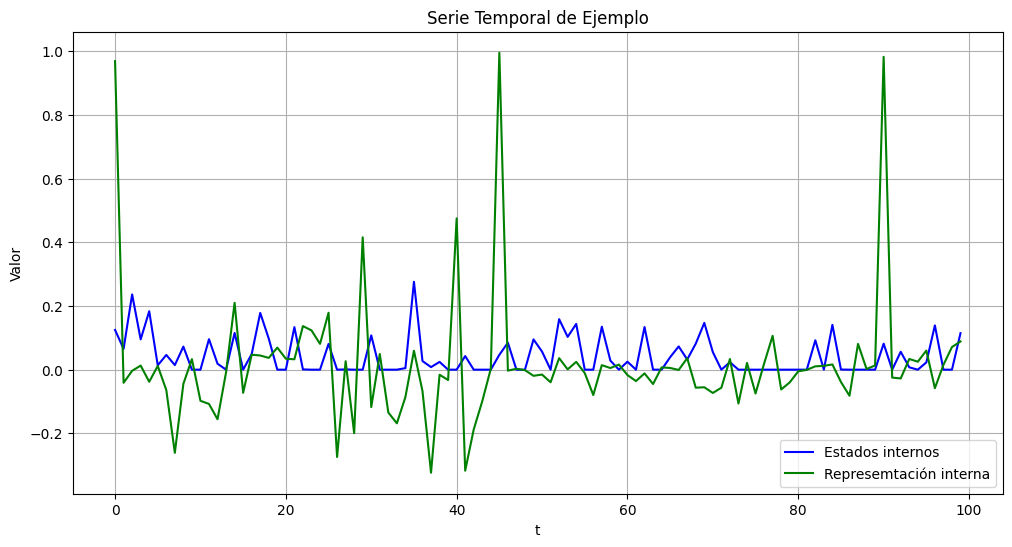

In [ ]:
plt.figure (figsize = (12, 6))
plt.plot (mts_representations_o[0,0:100], linestyle='-', color='b', label = 'Estados internos')
plt.plot (mts_representations_o1[0,0:100], linestyle='-', color='g', label = 'Represemtación interna')
# plt.plot (mts_representations_o2[0,0:100], linestyle='-', color='r', label = 'Hilbert')
plt.title ('Serie Temporal de Ejemplo')
plt.xlabel ('t')
plt.ylabel ('Valor')
plt.grid (True)
plt.legend ()
plt.show ()

## Matriz de similitud

In [ ]:
# Set the colormap for the histogram plot
cmap = cm.tab20(np.linspace(0, 1, 12))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

# Fix the random seed for reproducibility
np.random.seed(0)

# Compute a similarity matrix from the cosine similarity of the representations3
similarity_matrix = cosine_similarity (mts_representations_o)
#similarity_matrix = euclidean_distances (mts_representations_o)
similarity_matrix1 = cosine_similarity (mts_representations_o1)

# similarity_matrix2 = cosine_similarity (mts_representations_o2)
# Normalize the similarity in [0,1]
# Crear el normalizador Min-Max
#scaler = MinMaxScaler()

# Ajustar y transformar los datos
#similarity_matrix = scaler.fit_transform(similarity_matrix)


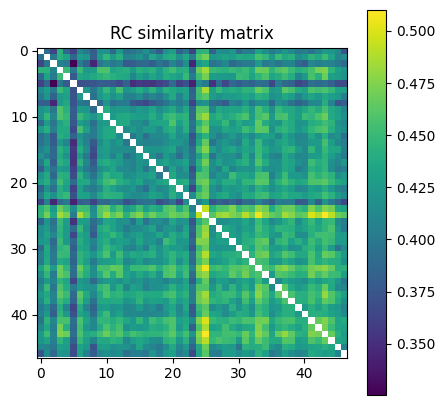

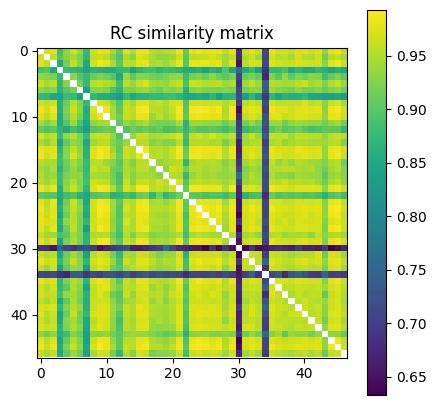

In [ ]:
np.fill_diagonal(similarity_matrix, np.nan)

# Plot similarity matrix
fig =  plt.figure(figsize=(5,5))
h = plt.imshow(similarity_matrix)
plt.title("RC similarity matrix")
plt.colorbar(h)
plt.show()

np.fill_diagonal(similarity_matrix1, np.nan)

# Plot similarity matrix
fig =  plt.figure(figsize=(5,5))
h = plt.imshow(similarity_matrix1)
plt.title("RC similarity matrix")
plt.colorbar(h)
plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_classification_report_table(report):
    lines = report.split('\n')

    classes = []
    metrics = ['precision', 'recall', 'f1-score', 'support']
    data = {'Class': [], 'Metric': [], 'Score': []}

    for line in lines[2:(len(lines)-5)]:
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        for i in range(1, 5):
            data['Class'].append(t[0])
            data['Metric'].append(metrics[i-1])
            data['Score'].append(float(t[i]))

    accuracy    = None
    support_acc = None
    for line in lines:
        line = line.strip()
        if line.startswith('accuracy'):
            accuracy_line = line.strip().split()
            try:
                accuracy    = float(accuracy_line[-2])  # Tomamos el último elemento como accuracy
                support_acc = float(accuracy_line[-1])  # Tomamos el último elemento como support
            except ValueError:
                accuracy = None
            break

    df = pd.DataFrame(data)

    plt.figure(figsize=(10, 6))

    # Crear tabla con Seaborn
    ax = sns.heatmap(pd.pivot_table(df, values='Score', index='Class', columns='Metric'),
                     annot=True, fmt=".2f", cmap="YlGnBu", cbar=False,
                     annot_kws={"fontsize": 12})  # Ajustar tamaño de fuente de las anotaciones

    # Añadir accuracy como título
    if accuracy is not None:
        plt.title(f'Classification Report\nAccuracy: {accuracy:.2f} . support: {support_acc}', fontsize=14, color='red')
    else:
        plt.title('Classification Report', fontsize=14, color='red')

    plt.tight_layout()
    plt.show()

def plot_classification_report_dic_table(report_dict):
    # Extract relevant metrics from the report dictionary
    classes = ['0', '1']  # Assuming classes are fixed for your case
    metrics = ['precision', 'recall', 'f1-score', 'support']

    data = {'Class': [], 'Metric': [], 'Score': []}

    # Extract per-class metrics
    for cls in classes:
        for metric in metrics:
            data['Class'].append(cls)
            data['Metric'].append(metric)
            data['Score'].append(report_dict[cls][metric])

    # Extract macro avg metrics
    for metric in metrics:
        data['Class'].append('macro avg')
        data['Metric'].append(metric)
        data['Score'].append(report_dict['macro avg'][metric])

    # Extract weighted avg metrics
    for metric in metrics:
        data['Class'].append('weighted avg')
        data['Metric'].append(metric)
        data['Score'].append(report_dict['weighted avg'][metric])

    # Extract accuracy
    accuracy = report_dict['accuracy']

    df = pd.DataFrame(data)

    plt.figure(figsize=(10, 6))

    # Create table using Seaborn
    ax = sns.heatmap(pd.pivot_table(df, values='Score', index='Class', columns='Metric'),
                     annot=True, fmt=".2f", cmap="YlGnBu", cbar=False,
                     annot_kws={"fontsize": 12})  # Adjust annotation font size

    # Highlight accuracy in red if available
    if accuracy is not None:
        for text in ax.texts:
            if text.get_text() == f'{accuracy:.2f}':
                text.set_color('red')  # Change accuracy text color to red
                text.set_weight('bold')  # Make accuracy text bold
        plt.title(f'Classification Report\nAccuracy: {accuracy:.2f}', fontsize=14, color='red')
    else:
        plt.title('Classification Report', fontsize=14)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(labels, labels_pred):
    # Calcular matriz de confusión
    cm = confusion_matrix(labels, labels_pred)

    # Obtener etiquetas únicas
    classes = np.unique(labels)

    # Crear plot de la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
# Crear etiquetas: 0 para 'young' y 1 para 'old'
labels_young = np.zeros(young.shape[0], dtype=int)
labels_old = np.ones(old.shape[0], dtype=int)

# Concatenar las etiquetas
true_y  = np.concatenate((labels_young, labels_old))
true_y_ = np.concatenate((labels_old, labels_young ))
print("Etiquetas verdaderas (true_y):")
print(true_y)
print(true_y_)

Etiquetas verdaderas (true_y):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1
 0 0 1 1 0 1 0 0 1 1]


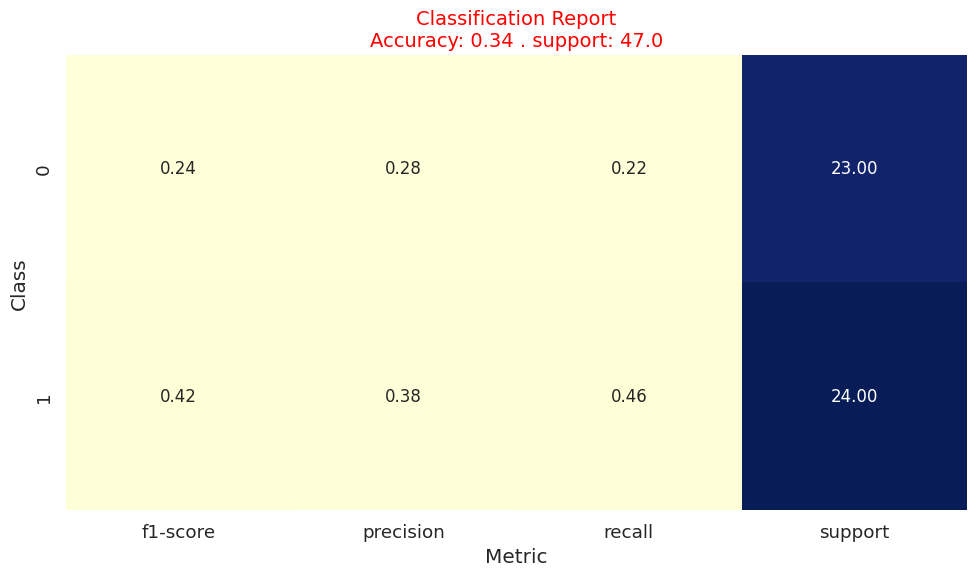

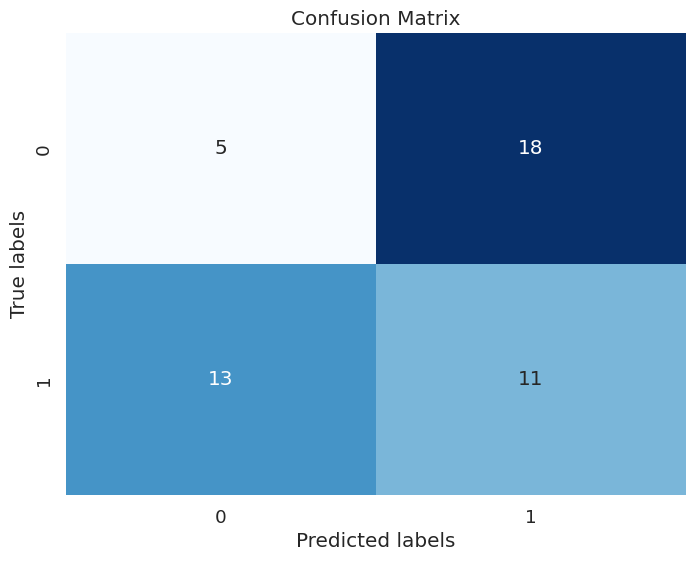

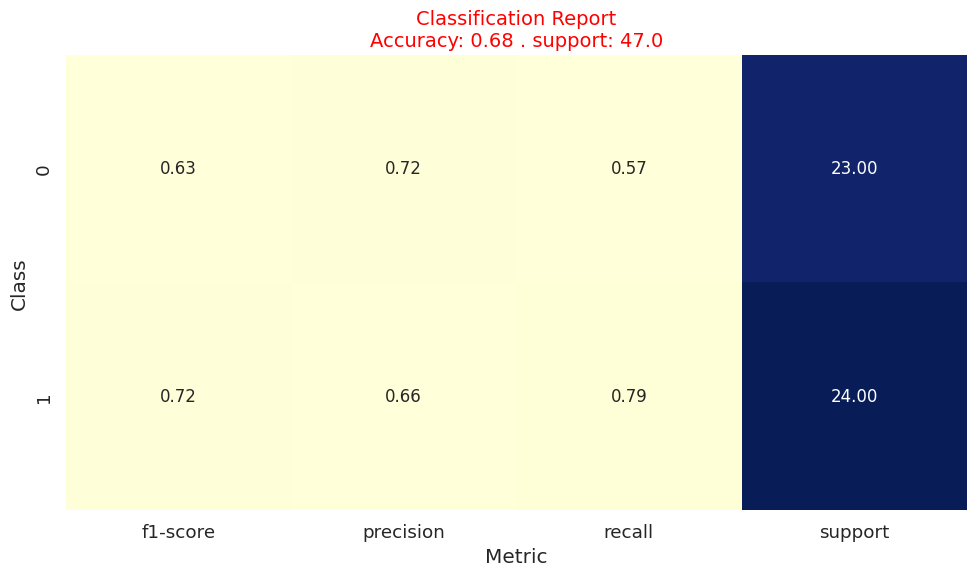

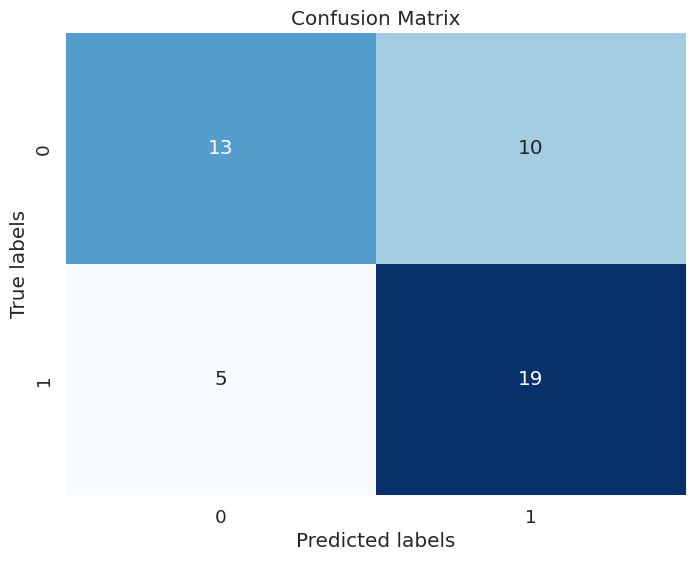

In [ ]:
from sklearn.metrics import classification_report
np.fill_diagonal(similarity_matrix, 0)
kmeans1 = KMeans (n_clusters = 2) # ,init='k-means++', random_state=0
kmeans1.fit_transform (similarity_matrix)
print (kmeans1.labels_)

report = classification_report(true_y, kmeans1.labels_)
plot_classification_report_table (report)
plot_confusion_matrix(true_y, kmeans1.labels_)

report = classification_report(true_y_, kmeans1.labels_)
plot_classification_report_table (report)
plot_confusion_matrix(true_y_, kmeans1.labels_)

[0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


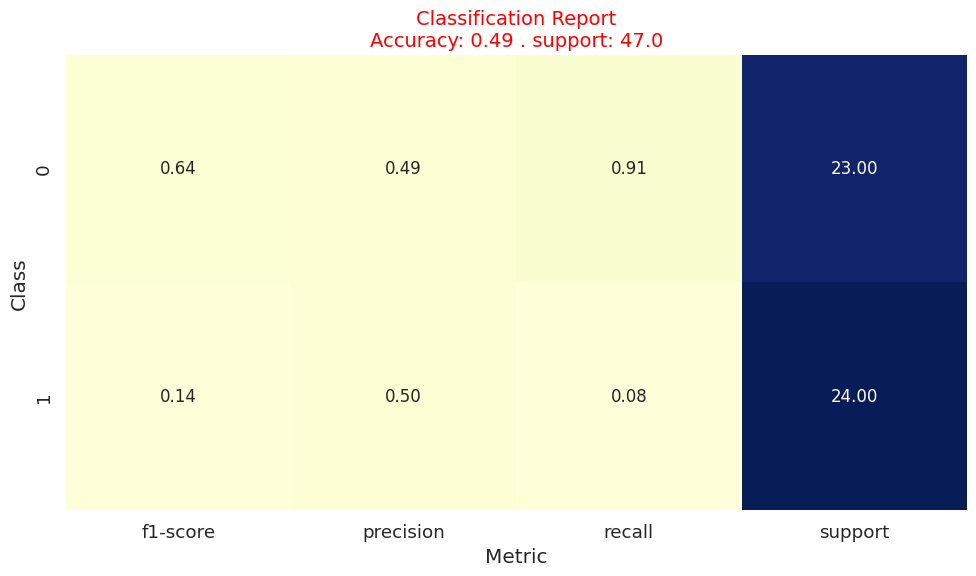

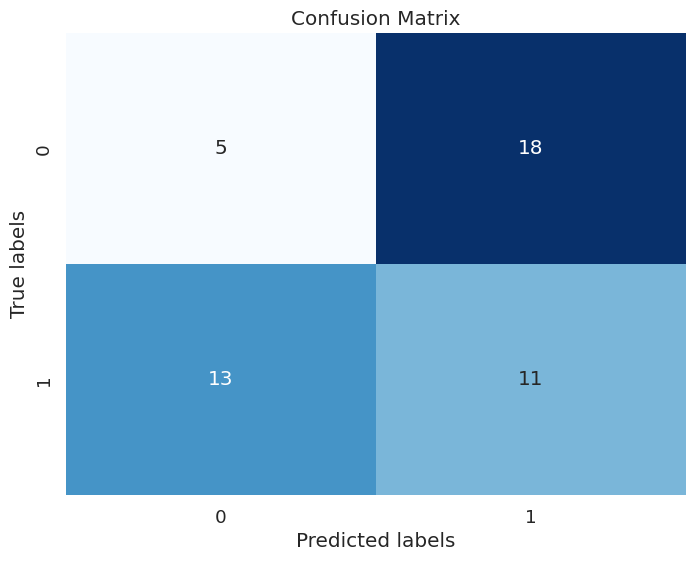

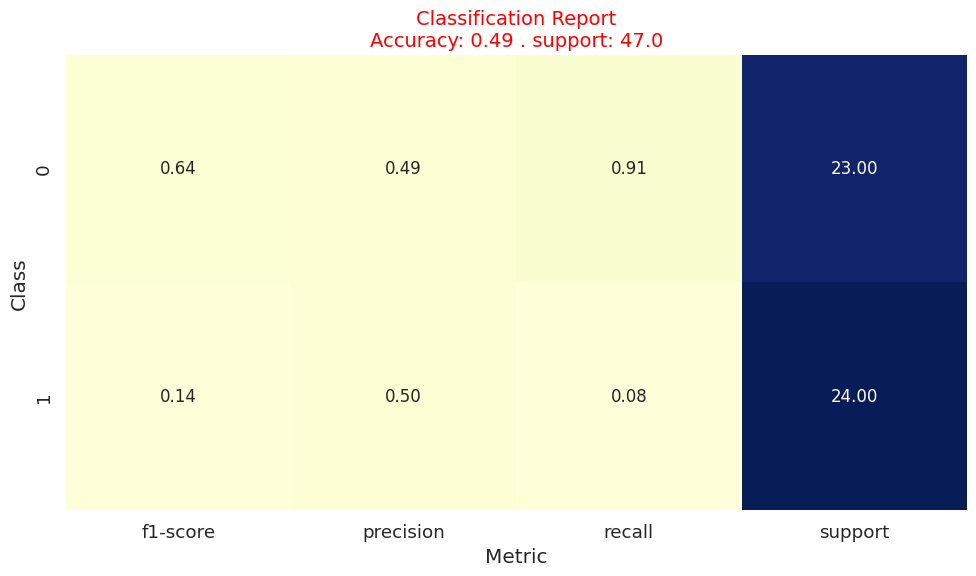

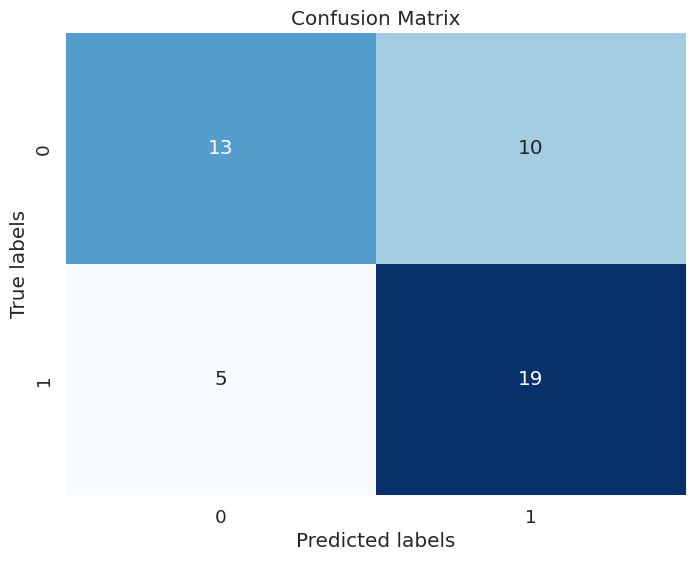

In [ ]:
from sklearn.metrics import classification_report
np.fill_diagonal(similarity_matrix1, 0)
kmeans      = KMeans (n_clusters = 2)# ,init='k-means++', random_state=0
labels_pred = kmeans.fit_predict (similarity_matrix1)
print (labels_pred)

report = classification_report(true_y, labels_pred)
plot_classification_report_table (report)
plot_confusion_matrix(true_y, kmeans1.labels_)

report = classification_report(true_y_, labels_pred)
plot_classification_report_table (report)
plot_confusion_matrix(true_y_, kmeans1.labels_)

Best Accuracy: 0.723404255319149
Best Report: {'0': {'precision': 0.7083333333333334, 'recall': 0.7391304347826086, 'f1-score': 0.723404255319149, 'support': 23}, '1': {'precision': 0.7391304347826086, 'recall': 0.7083333333333334, 'f1-score': 0.723404255319149, 'support': 24}, 'accuracy': 0.723404255319149, 'macro avg': {'precision': 0.723731884057971, 'recall': 0.723731884057971, 'f1-score': 0.723404255319149, 'support': 47}, 'weighted avg': {'precision': 0.7240595127967933, 'recall': 0.723404255319149, 'f1-score': 0.723404255319149, 'support': 47}}


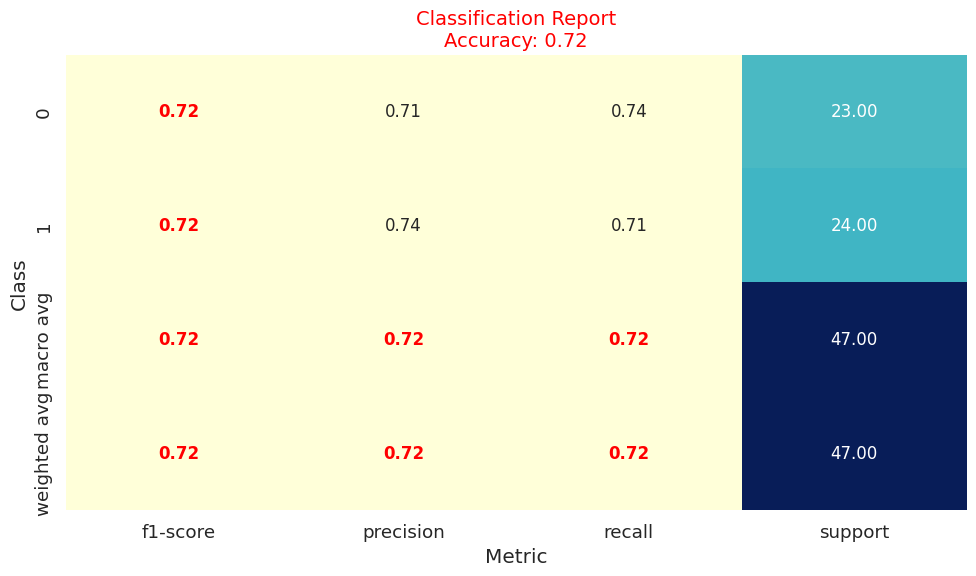

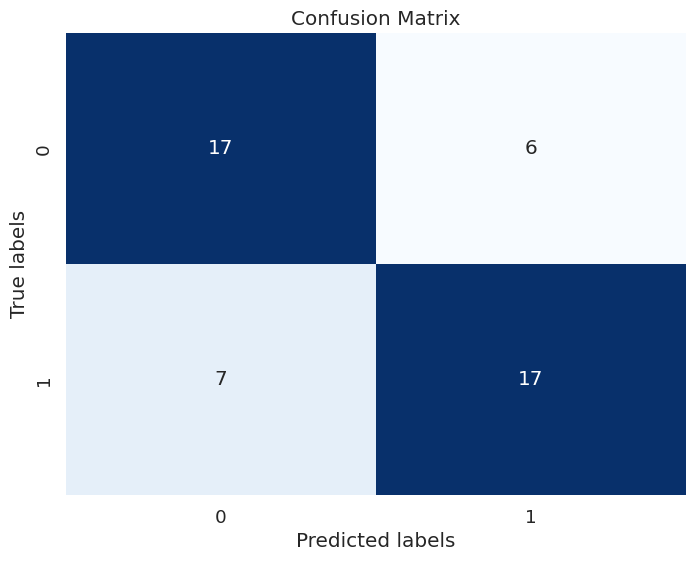

Best Accuracy: 0.6808510638297872
Best Report: {'0': {'precision': 0.6333333333333333, 'recall': 0.8260869565217391, 'f1-score': 0.7169811320754716, 'support': 23}, '1': {'precision': 0.7647058823529411, 'recall': 0.5416666666666666, 'f1-score': 0.6341463414634146, 'support': 24}, 'accuracy': 0.6808510638297872, 'macro avg': {'precision': 0.6990196078431372, 'recall': 0.6838768115942029, 'f1-score': 0.6755637367694431, 'support': 47}, 'weighted avg': {'precision': 0.7004171881518565, 'recall': 0.6808510638297872, 'f1-score': 0.6746825155927192, 'support': 47}}


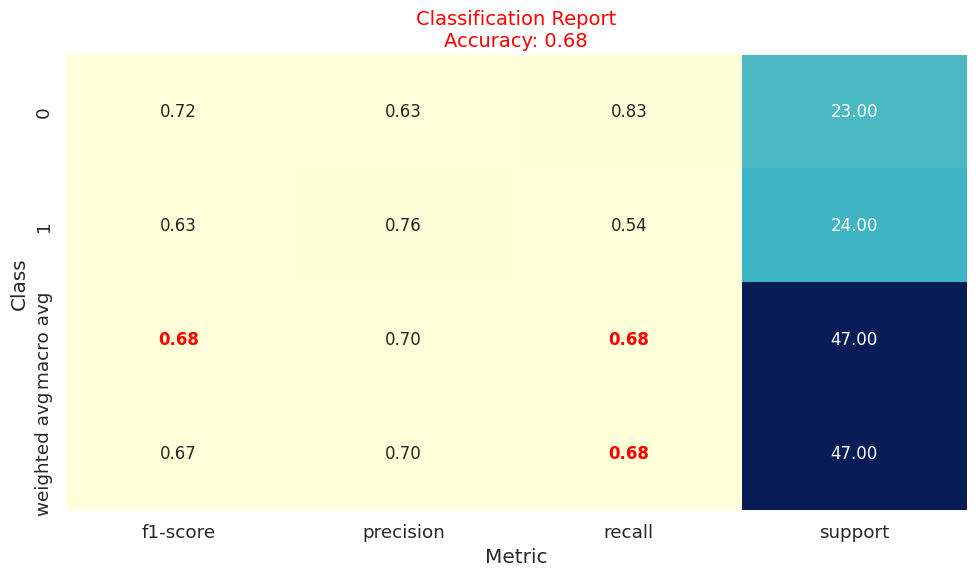

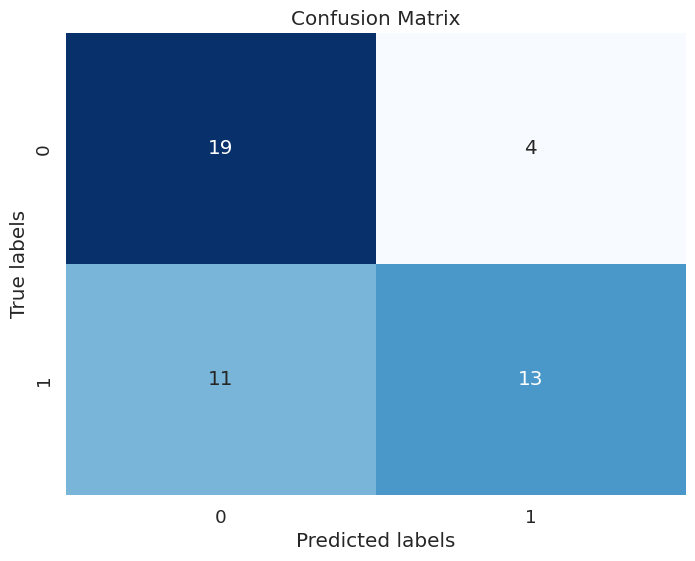

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score

def find_best_kmeans(similarity_matrix, true_labels, n_runs=10, n_clusters=2):
    best_accuracy = 0
    best_labels = None
    best_report = None

    for _ in range(n_runs):
        # Inicializar y ajustar KMeans
        kmeans = KMeans(n_clusters=n_clusters, n_init=10)  # n_init=10 para usar 10 inicializaciones diferentes por cada ajuste
        labels_pred = kmeans.fit_predict(similarity_matrix)

        # Evaluar la precisión
        report = classification_report (true_labels, labels_pred, output_dict = True)
        accuracy = report['accuracy']

        # Si la precisión es la mejor hasta ahora, guardarla
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_labels = labels_pred
            best_report = report

    return best_labels, best_report, best_accuracy

# Suponiendo que true_y es el vector de etiquetas verdaderas y similarity_matrix1 es tu matriz de similitud
np.fill_diagonal(similarity_matrix, 0)
best_labels, best_report, best_accuracy = find_best_kmeans (similarity_matrix, true_y, n_runs = 9500)

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Report: {best_report}")

plot_classification_report_dic_table (best_report)
plot_confusion_matrix(true_y, best_labels)

np.fill_diagonal(similarity_matrix1, 0)
best_labels, best_report, best_accuracy = find_best_kmeans (similarity_matrix1, true_y, n_runs = 9500)

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Report: {best_report}")

plot_classification_report_dic_table (best_report)
plot_confusion_matrix(true_y, best_labels)

# Gráficos de recurrencia

In [ ]:
!git clone https://github.com/pik-copan/pyunicorn.git
%cd pyunicorn
!pip install .
!pip install pyts

fatal: destination path 'pyunicorn' already exists and is not an empty directory.
/content/drive/MyDrive/eeg_data/pyunicorn
Processing /content/drive/MyDrive/eeg_data/pyunicorn
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.9 MB/s eta 0:00:00
  Created wheel for pyunicorn: filename=pyunicorn-0.7.1a1-cp310-cp310-linux_x86_64.whl size=2558076 sha256=679f25a1b2c3a76c660910894eb44dd413fd2c07cc19b3b4d42c50c96a012554
  Stored in directory: /tmp/pip-ephem-wheel-cache-l9neipgc/wheels/8e/c0/f6/05ddc6b88f7e500de4bef6b26f86e4b01ecd00a6b40f0668b8
Successfully built pyunicorn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.5 MB/s eta 0:00:00


(47, 640)


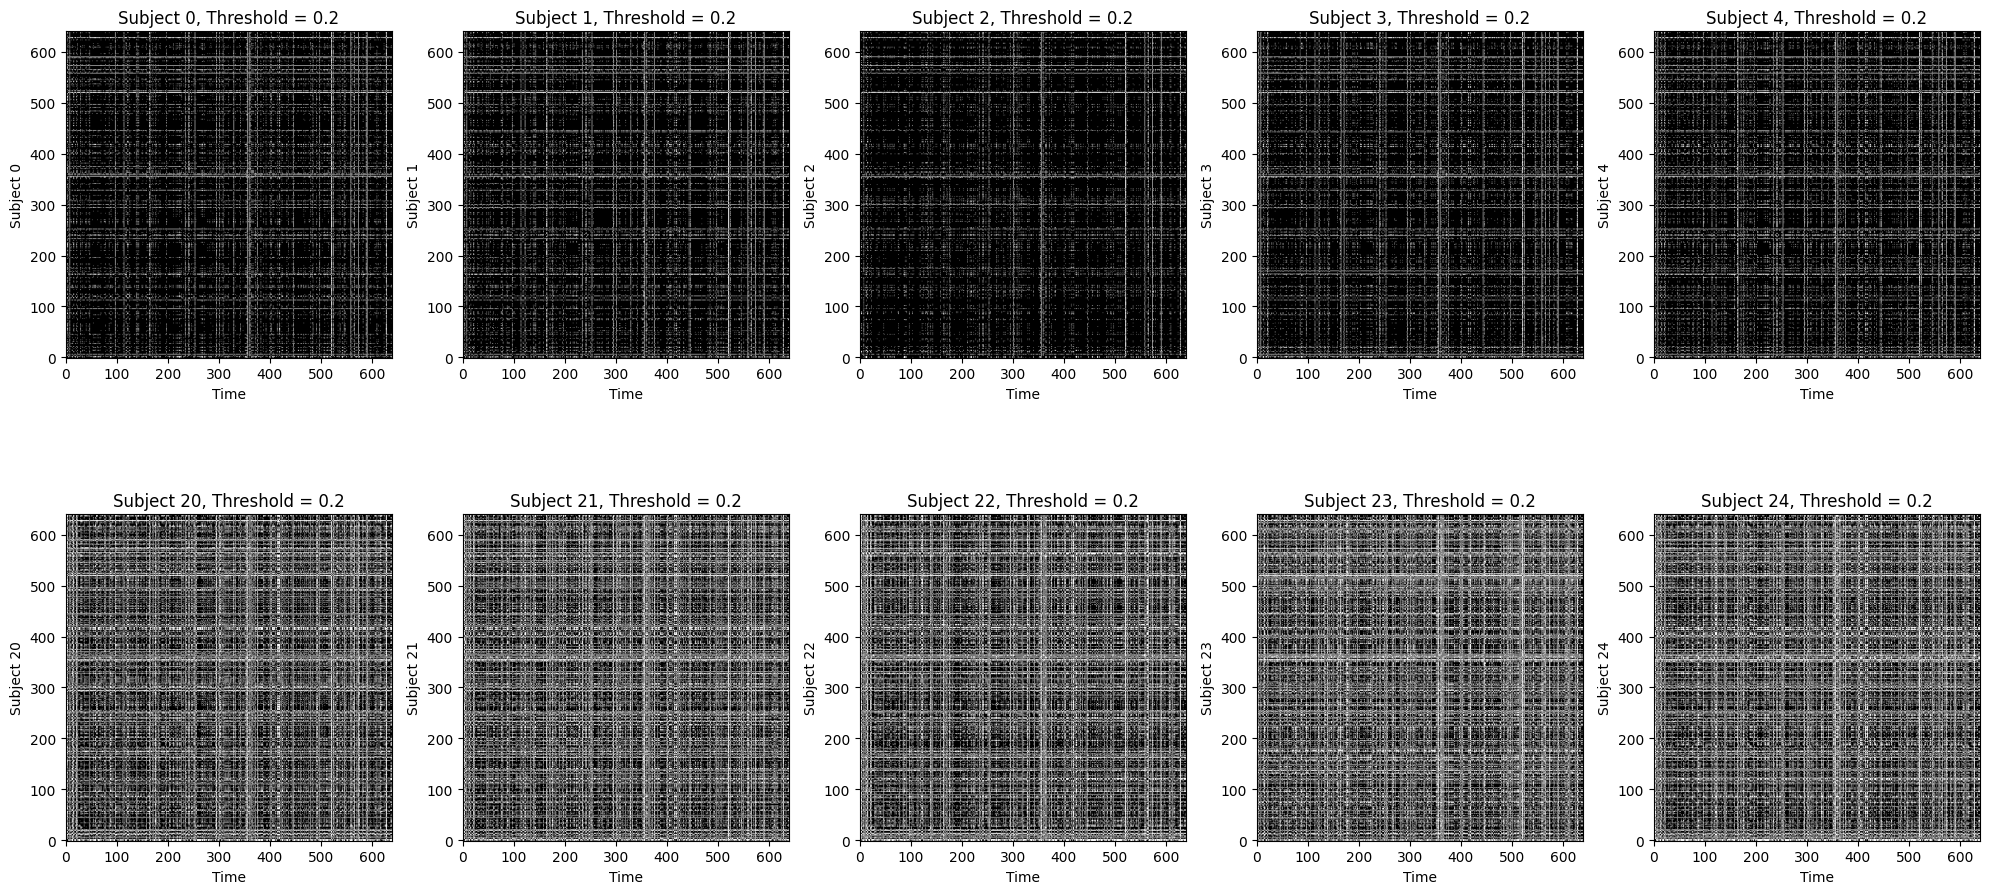

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyunicorn.timeseries.recurrence_plot import RecurrencePlot


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import MinMaxScaler
from pyts.image import RecurrencePlot as Recu

def plot_recurrence_for_subjects(data, thresholds=[0.1, 0.2, 0.3]):
    """
    Genera y visualiza una gráfica recurrente para cada sujeto en el dataset.

    :param data: numpy array de forma (n_sujetos, n_features), donde n_sujetos es el número de sujetos
                 y n_features es la representación interna del RC para cada sujeto.
    :param thresholds: lista de valores de umbral para la recurrencia.
    """
    n_subjects = data.shape[0]

    for subject_index in range(n_subjects):
        # Obtener los datos para el sujeto actual
        subject_data = data[subject_index]

        # Normalizar los datos del sujeto
        #subject_data_normalized = (subject_data - np.mean(subject_data)) / np.std(subject_data)

        for threshold in thresholds:
            # Creación de la gráfica recurrente con el umbral especificado
            rp = RecurrencePlot(subject_data.reshape(-1, 1), threshold=threshold)

            # Obtener la matriz de recurrencia
            recurrence_matrix = rp.recurrence_matrix()

            # Verificación de la matriz de recurrencia
            if np.sum(recurrence_matrix) == 0:
                print(f'La matriz de recurrencia para el sujeto {subject_index} con umbral {threshold} está vacía.')
                continue

            # Visualización de la gráfica recurrente
            plt.figure()
            plt.imshow(recurrence_matrix, cmap='binary', origin='lower')
            plt.xlabel('Time')
            plt.ylabel('Time')
            plt.title(f'Recurrence Plot for Subject {subject_index} with Threshold {threshold}')
            plt.show()

def plot_recurrence_for_subjects_group(data, young_subjects, old_subjects, thresholds=[0.1, 0.2, 0.3]):
    """
    Genera y visualiza matrices de recurrencia para sujetos jóvenes y mayores.

    Parameters:
    data (numpy.ndarray): Datos de representación de los sujetos.
    young_subjects (list): Índices de los sujetos jóvenes.
    old_subjects (list): Índices de los sujetos mayores.
    thresholds (list): Lista de valores de umbral para la recurrencia.
    """
    n_young = len(young_subjects)
    n_old = len(old_subjects)
    n_thresholds = len(thresholds)

    # Calcular número total de subplots necesarios
    n_plots = max(n_young, n_old) * n_thresholds

    # Crear la figura con subplots adecuados
    fig, axes = plt.subplots(nrows=2, ncols=max(n_young, n_old) * n_thresholds, figsize=(20, 10))

    # Iterar sobre los umbrales
    for j, threshold in enumerate(thresholds):
        # Iterar sobre los sujetos jóvenes
        for i, subject_index in enumerate(young_subjects):
            # Determinar el índice correcto del subplot
            subplot_index = i * n_thresholds + j
            ax = axes[0, subplot_index]

            # Obtener datos del sujeto y normalizarlos
            subject_data = data[subject_index]
            subject_data_normalized = MinMaxScaler().fit_transform(subject_data.reshape(-1, 1)).flatten()

            # Crear plot de matriz de recurrencia
            rp = Recu (threshold=threshold)
            recurrence_matrix = rp.fit_transform(subject_data.reshape(1, -1))[0]

            # Mostrar matriz de recurrencia en el subplot correspondiente
            ax.imshow(recurrence_matrix, cmap='binary', origin='lower')
            ax.set_xlabel('Time')
            ax.set_ylabel(f'Subject {subject_index}')
            ax.set_title(f'Subject {subject_index}, Threshold = {threshold}')

        # Iterar sobre los sujetos mayores
        for k, subject_index in enumerate(old_subjects):
            # Determinar el índice correcto del subplot
            subplot_index = k * n_thresholds + j
            ax = axes[1, subplot_index]

            # Obtener datos del sujeto y normalizarlos
            subject_data = data[subject_index]
            subject_data_normalized = MinMaxScaler().fit_transform(subject_data.reshape(-1, 1)).flatten()

            # Crear plot de matriz de recurrencia
            rp = Recu (threshold=threshold)
            recurrence_matrix = rp.fit_transform(subject_data_normalized.reshape(1, -1))[0]

            # Mostrar matriz de recurrencia en el subplot correspondiente
            ax.imshow(recurrence_matrix, cmap='binary', origin='lower')
            ax.set_xlabel('Time')
            ax.set_ylabel(f'Subject {subject_index}')
            ax.set_title(f'Subject {subject_index}, Threshold = {threshold}')

    plt.tight_layout()
    plt.show()

# Ejemplo de uso con datos aleatorios (reemplaza esto con tus datos reales)
mean_transitorios = np.mean(rc_state, axis=1)
last_transitorio = rc_state[ :, -1, :]
mts_rep_reshaped = mean_transitorios #mts_representations_o1
print (mts_rep_reshaped.shape)
young_subjects = [0, 1, 2, 3, 4]   # Ejemplo de índices reducidos
old_subjects = [20, 21, 22, 23, 24]   # Ejemplo de índices reducidos


plot_recurrence_for_subjects_group(mts_rep_reshaped, young_subjects, old_subjects, thresholds=[0.2]) #, 0.2, 0.3


# Potencial de Memoria

In [ ]:
import numpy as np

def calculate_potential_memory(mts_representations, tolerance = 0.05):
    """
    Calculate the potential memory for given multivariate time series representations.

    Parameters:
    mts_representations (numpy.ndarray): The multivariate time series representations.
    tolerance (float): The tolerance threshold to consider the memory potential. Default is 0.05.

    Returns:
    list: A list containing the potential memory for each representation.
    """
    potential_memory = []

    for representation in mts_representations:
        y_initial = representation [0]

        for t, y_t in enumerate(representation[1:], start=1):
            if np.linalg.norm(y_t - y_initial) < tolerance:
                potential_memory.append(t)
                break
    return potential_memory
################################
# mts_representations = mts_representations_o
mts_representations = mts_representations_o
print("Dimensiones de mts_representations:", mts_representations.shape)

# Calculate the potential memory for young adult subjects
potential_memory_young_adults = calculate_potential_memory (mts_representations [:23])
# Calculate the potential memory for older subjects
potential_memory_older_adults = calculate_potential_memory (mts_representations [24:])

# Imprimir los resultados
print("Memoria potencial para sujetos jóvenes adultos:", potential_memory_young_adults)
print("Memoria potencial para sujetos mayores:", potential_memory_older_adults)

Dimensiones de mts_representations: (47, 50726400)
Memoria potencial para sujetos jóvenes adultos: [3, 2, 5, 1, 2, 1, 2, 2, 2, 1, 3, 23, 56, 2, 3, 1, 1, 11, 2, 3, 19, 3, 48]
Memoria potencial para sujetos mayores: [1, 229, 3, 2, 3, 3, 1, 3, 2, 2, 1, 1, 1, 22, 2, 1, 1, 3, 2, 1, 1, 2, 2]


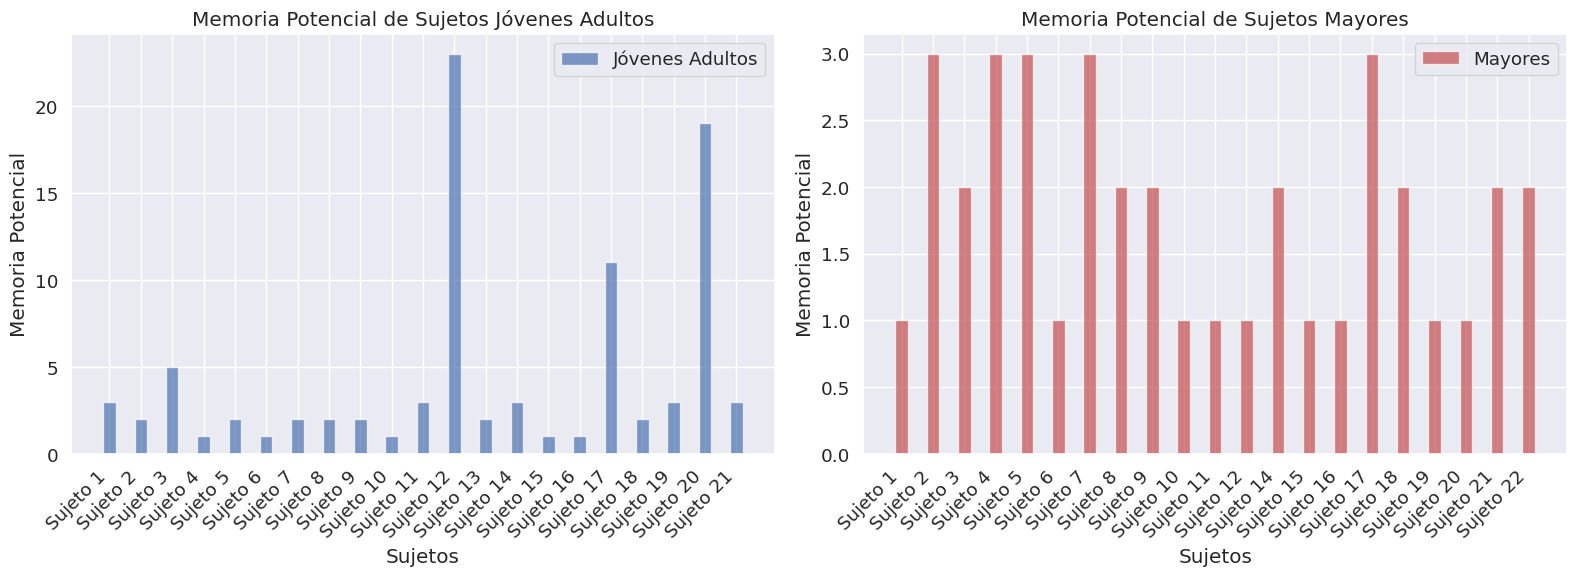

In [ ]:
import matplotlib.pyplot as plt

# Datos de memoria potencial para sujetos jóvenes adultos
# Datos de memoria potencial para sujetos jóvenes adultos
# Datos de memoria potencial para sujetos jóvenes adultos
memoria_jovenes   = potential_memory_young_adults #[5, 1, 3, 2, 1, 5, 1, 30, 1, 2, 183, 3, 2, 1, 1, 13, 3, 2, 1, 2, 6, 1, 1]
etiquetas_jovenes = [f'Sujeto {i+1}' for i in range (len (memoria_jovenes))]

# Datos de memoria potencial para sujetos mayores
memoria_mayores   = potential_memory_older_adults #[1, 3, 1, 1, 2, 1, 1, 2, 1, 1, 13, 1, 3, 1, 1, 1, 2, 3, 6, 3, 1, 1, 1]
etiquetas_mayores = [f'Sujeto {i+1}' for i in range (len (memoria_mayores))]

# Eliminar el valor máximo para poder representar gráficamente los resultados
max_memoria_jovenes = max(memoria_jovenes)
max_memoria_mayores = max(memoria_mayores)

etiquetas_jovenes.remove(etiquetas_jovenes[memoria_jovenes.index(max_memoria_jovenes)])
etiquetas_mayores.remove(etiquetas_mayores[memoria_mayores.index(max_memoria_mayores)])

memoria_jovenes.remove (max_memoria_jovenes)
memoria_mayores.remove (max_memoria_mayores)

# Crear figura y ejes para los dos subplots
fig, (ax1, ax2) = plt.subplots (1, 2, figsize = (16, 6))  # 1 fila, 2 columnas

# Barras para sujetos jóvenes adultos
ax1.bar (etiquetas_jovenes, memoria_jovenes, width = 0.4, align = 'center', label = 'Jóvenes Adultos', color = 'b', alpha = 0.7)

# Etiquetas y título para el primer subplot
ax1.set_xlabel ('Sujetos')
ax1.set_ylabel ('Memoria Potencial')
ax1.set_title ('Memoria Potencial de Sujetos Jóvenes Adultos')
ax1.set_xticks (range (len (etiquetas_jovenes)))
ax1.set_xticklabels (etiquetas_jovenes, rotation = 45, ha = 'right')
ax1.legend ()

# Barras para sujetos mayores
ax2.bar (etiquetas_mayores, memoria_mayores, width = 0.4, align = 'center', label = 'Mayores', color = 'r', alpha = 0.7)

# Etiquetas y título para el segundo subplot
ax2.set_xlabel ('Sujetos')
ax2.set_ylabel ('Memoria Potencial')
ax2.set_title ('Memoria Potencial de Sujetos Mayores')
ax2.set_xticks (range(len(etiquetas_mayores)))
ax2.set_xticklabels (etiquetas_mayores, rotation = 45, ha = 'right')
ax2.legend ()

# Ajustar diseño y mostrar la figura con ambos subplots
plt.tight_layout ()
plt.show ()


# ***SUERVISADO -LIN-SVM-OVR-MLP-***

In [ ]:
eeg_channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

# Definición de los subgrupos de canales
coronal_subgroups = {
    "prefrontal": ['Fp1', 'Fp2', 'AF7', 'AF8', 'AF3', 'AF4', 'AFz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'Fz'],
    "frontal": ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'Fz'],
    "central": ['C3', 'C4', 'Cz'],
    "parietal": ['P3', 'P4', 'Pz'],
    "occipital": ['O1', 'O2', 'Oz']
}
84
sagittal_subgroups = {
    "left": ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1'],
    "center": ['Fpz', 'AFz', 'Fz', 'Cz', 'Pz', 'Oz', 'POz', 'CPz'],
    "right": ['Fp2', 'AF8', 'AF4', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
}

# Función para obtener los índices
def get_indices(subgroup, eeg_channels):
    return [eeg_channels.index(ch) for ch in subgroup if ch in eeg_channels]

# Obtener los índices para cada subgrupo coronal
coronal_indices = {region: get_indices(channels, eeg_channels) for region, channels in coronal_subgroups.items()}

# Obtener los índices para cada subgrupo sagital
sagittal_indices = {region: get_indices(channels, eeg_channels) for region, channels in sagittal_subgroups.items()}

print("Coronal indices:", coronal_indices)
print("Sagittal indices:", sagittal_indices)


idx_channels = sagittal_indices ['left']  #coronal_indices ['frontal'] + coronal_indices ['prefrontal']
print("Frontal indices:", idx_channels)


Coronal indices: {'prefrontal': [0, 33, 1, 34, 2, 35, 36, 3, 38, 4, 39, 5, 40, 6, 41, 37], 'frontal': [3, 38, 4, 39, 5, 40, 6, 41, 37], 'central': [12, 49, 47], 'parietal': [20, 57, 30], 'occipital': [26, 63, 28]}
Sagittal indices: {'left': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], 'center': [32, 36, 37, 47, 30, 28, 29, 31], 'right': [33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]}
Frontal indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [ ]:
num_input = len (eeg_channels)

Datos con todos los canales y eliminación de artefactos

In [ ]:
old = np.load('./dtset/dt_Older_eeg_ICA_30_4.npy')
young = np.load('./dtset/dt_Younger_eeg_ICA_30_4.npy')

Datos de lso canales SIN ekliminación de artefactos

In [ ]:
old = np.load('./dtset/dt_Older_eeg_30_4.npy')
young = np.load('./dtset/dt_Younger_eeg_30_4.npy')

In [ ]:
min_length = min(young.shape [1], old.shape [1])

# Recortar los datasets para que tengan el mismo tamaño
young = young[:,:min_length,0:num_input]
old = old[:,:min_length,0:num_input]
# young = young [ :, :, idx_channels]
# old   = old [:, :, idx_channels]

# Concatenar los datasets
X = np.concatenate((young, old), axis=0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def standardize_eeg_signals_opt (X):
    """
    Estandariza las señales de EEG para cada canal de cada sujeto.

    Args:
        X (np.ndarray): Datos de entrada con forma (n_subjects, n_samples, n_channels).

    Returns:
        X_standardized (np.ndarray): Datos estandarizados con la misma forma que X.
    """
    # Copiar X para almacenar los datos estandarizados
    X_standardized = np.copy(X)

    # Función para estandarizar un canal completo
    def standardize_channel (channel_data):
        scaler = StandardScaler ()
        return scaler.fit_transform (channel_data.reshape (-1, 1)).flatten ()

    # Aplicar la estandarización a cada canal para cada sujeto
    for i in range (X.shape [0]):  # Iterar sobre cada sujeto
        X_standardized [i] = np.apply_along_axis (standardize_channel, 0, X [i])

    return X_standardized
# Crear el normalizador Min-Max
scaler = StandardScaler()

# Ajustar y transformar los datos
# X = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape[0], X.shape[1], X.shape[2])
X = standardize_eeg_signals_opt (X)
# Verificar las formas resultantes
print("Forma de los datos concatenados:", X.shape)

Forma de los datos concatenados: (47, 39680, 64)


In [ ]:
# Etiquetas para dataset_RC_y
labels_y = np.zeros((young.shape[0], 1))  # Dos columnas para etiquetas binarias
labels_y[:] = 0  # Columna 1 con valor 0 para dataset_RC_y

# Etiquetas para dataset_RC_o
labels_o = np.zeros((old.shape[0], 1))  # Dos columnas para etiquetas binarias
labels_o[:] = 1  # Columna 1 con valor 1 para dataset_RC_o


In [ ]:
Y = np.concatenate((labels_y,labels_o),axis=0)
Y = Y.astype(int)
Y = Y.ravel()
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1])

In [ ]:
from sklearn.model_selection import train_test_split
# Dividir los sujetos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state = 0)

print ("Dimensiones de los datos de entrenamiento:", X_train.shape)
print ("Dimensiones de las etiquetas de entrenamiento:", y_train.shape)
print("Dimensiones de los datos de prueba:", X_test.shape)
print("Dimensiones de las etiquetas de prueba:", y_test.shape)

Dimensiones de los datos de entrenamiento: (28, 39680, 64)
Dimensiones de las etiquetas de entrenamiento: (28,)
Dimensiones de los datos de prueba: (19, 39680, 64)
Dimensiones de las etiquetas de prueba: (19,)


# ***Readout:lin (ridge)***

In [ ]:
config_clas  = {
    'seed': 1,
    'init_type':'orthogonal',
    'init_std':0.1,
    'init_mean':0,
    'input_size': num_input,
    'n_internal_units': num_input*10,
    'spectral_radius': 1,
    'leak': 0.3,
    'input_scaling':0.1,
    'nonlinearity':'relu', # 'relu','tanh'
    'connectivity': 0.1,
    'noise_level': 0.1,
    'n_drop': None,
    'washout':'init',
    'use_input_bias':True,
    'use_input_layer':True,
    'mts_rep': 'reservoir',
    'w_ridge_embedding':18.80,
    'bidir': True,
    'circle': False,
    'dimred_method': None,
    'n_dim': 36,
    'readout_type': 'lin',
    'threshold':0.6,
    'svm_kernel': 'rbf', # 'sigmoid', 'rbf', 'poly', 'linear', 'precomputed'
    'svm_gamma': 0.05,
    'svm_C': 10.0,
    'w_ridge':  0.1,
    'mlp_num_epochs': 200,
    'mlp_batch_size': 128,
    'mlp_learning_rate': 0.1,
    'mlp_learning_rate_type': 'adaptive',  # 'constant' or 'adaptive'
    'mlp_layout': (10, 10),
    'mlp_w_l2': 0.1,
    'plasticity_synaptic': None, # 'hebb'.'oja', 'covariance'
    'theta_m':0.01,
    'learning_rate': 0.001,
    'plasticity_intrinsic':None, # 'excitability', 'activation_function'
    'new_activation_function':'tanh',
    'excitability_factor':0.01,
    'device': 'cpu'
}
model_esn_clas   = MyESN  (config_clas)
model_esn_clas.config

{'seed': 1,
 'init_type': 'orthogonal',
 'init_std': 0.1,
 'init_mean': 0,
 'input_size': 64,
 'n_internal_units': 640,
 'spectral_radius': 1,
 'leak': 0.3,
 'input_scaling': 0.1,
 'nonlinearity': 'relu',
 'connectivity': 0.1,
 'noise_level': 0.1,
 'n_drop': None,
 'washout': 'init',
 'use_input_bias': True,
 'use_input_layer': True,
 'mts_rep': 'reservoir',
 'w_ridge_embedding': 18.8,
 'bidir': True,
 'circle': False,
 'dimred_method': None,
 'n_dim': 36,
 'readout_type': 'lin',
 'threshold': 0.6,
 'svm_kernel': 'rbf',
 'svm_gamma': 0.05,
 'svm_C': 10.0,
 'w_ridge': 0.1,
 'mlp_num_epochs': 200,
 'mlp_batch_size': 128,
 'mlp_learning_rate': 0.1,
 'mlp_learning_rate_type': 'adaptive',
 'mlp_layout': (10, 10),
 'mlp_w_l2': 0.1,
 'plasticity_synaptic': None,
 'theta_m': 0.01,
 'learning_rate': 0.001,
 'plasticity_intrinsic': None,
 'new_activation_function': 'tanh',
 'excitability_factor': 0.01,
 'device': 'cpu'}

In [ ]:
# Instanciar un objeto MyRC
my_rc = MyRC(model_esn_clas, config_clas)

# result_rc  = my_rc_clus_o.fit (X)
# Devolvemos: Estados internos neuronas, Etados internos reducidos a PCA, Representación estados internos, Readout
# rc_state, rc_dim_states, input_repr, output_redout_layer = result_rc
result_rc  = my_rc.fit (X_train, y_train)
rc_state, rc_dim_states, input_repr, output_redout_layer = result_rc
print (f'rc_state:{rc_state.shape}')
print (f'input_repr:{input_repr.shape}')
print (f'output_redout_layer:{output_redout_layer}')

* get_states : reservoir_state_b : torch.Size([28, 39680, 640])
fit :  self.mts_rep_state: (28, 79360, 640)
fit :  self.dimred_method: None
fit : rc_dim_states:(28, 79360, 640)
fit : input_repr:(28, 410240)
lin : output_rc_layer:Ridge(alpha=0.1, random_state=0)
rc_state:(28, 79360, 640)
input_repr:(28, 410240)
output_redout_layer:Ridge(alpha=0.1, random_state=0)


In [ ]:
mts_representations_s = rc_state.reshape(47, -1)
# Set the colormap for the histogram plot
cmap = cm.tab20(np.linspace(0, 1, 12))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

# Fix the random seed for reproducibility
np.random.seed(0)

# Compute a similarity matrix from the cosine similarity of the representations3
similarity_matrix = cosine_similarity (mts_representations_s)

np.fill_diagonal(similarity_matrix, np.nan)

# Plot similarity matrix
fig =  plt.figure(figsize=(5,5))
h = plt.imshow(similarity_matrix)
plt.title("RC similarity matrix")
plt.colorbar(h)
plt.show()


fit_evaluate :Yte: [1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1]
* get_states : reservoir_state_b : torch.Size([19, 39680, 640])
fit_evaluate :rc_state_xte: (19, 79360, 640)
fit_evaluate :n_tr_drop: None
fit_evaluate :rc_dim_state_xte: (19, 79360, 640)
fit_evaluate : input_repr_xte: (19, 410240)
fit_evaluate : self.readout_type : lin
fit_evaluate :lin :logits : [0.59123373 0.1966039  0.09180725 0.08014381 0.19972497 0.16638342
 0.5314929  0.68877727 0.1202611  0.27734032 0.53134936 0.58065695
 0.45951092 0.47313336 0.4725306  0.6187951  0.39032894 0.38824564
 0.64955217]
fit_evaluate :lin :pred_prob : [0.64364815 0.54899323 0.5229357  0.5200252  0.54976594 0.54150015
 0.62983125 0.66569483 0.53002906 0.5688941  0.6297978  0.64121854
 0.6128981  0.61612517 0.61598253 0.6499444  0.5963619  0.5958603
 0.6569095 ]
fit_evaluate :lin :pred_class : [1 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1]
fit_evaluate :Yte : [1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1]
fit_evaluate :pred_class : [1 0 0 0 0 0 1 1 0 0 1 1 

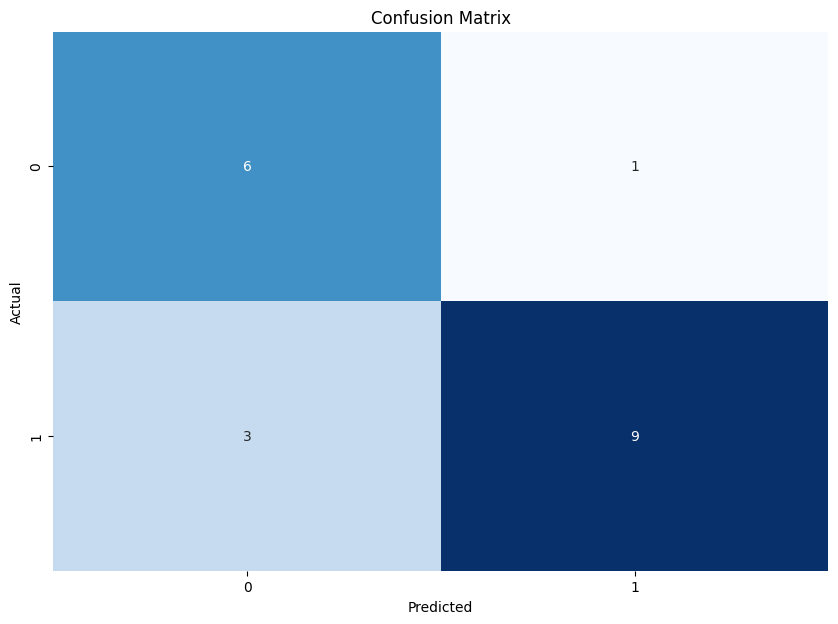

Accuracy: 0.7894736842105263
Precision: 0.8140350877192982
Recall: 0.7894736842105263
F1 Score: 0.7930622009569378
ROC AUC Score: 0.8035714285714286


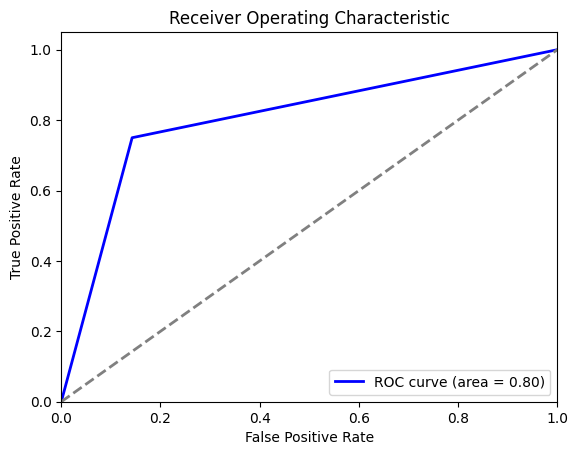

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.90      0.75      0.82        12

    accuracy                           0.79        19
   macro avg       0.78      0.80      0.78        19
weighted avg       0.81      0.79      0.79        19

rc_state_xte:(19, 79360, 640)
input_repr_xte:(19, 410240)
* report :               precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.90      0.75      0.82        12

    accuracy                           0.79        19
   macro avg       0.78      0.80      0.78        19
weighted avg       0.81      0.79      0.79        19

 ************** FIN CLASIFICACION  ************************************


In [ ]:
# EValuar el modelo
result_eval = my_rc.fit_evaluate (X_test, y_test)

rc_state_xte, rc_dim_state_xte, input_repr_xte, report = result_eval
print (f'rc_state_xte:{rc_state_xte.shape}')
print (f'input_repr_xte:{input_repr_xte.shape}')

## ## ## ## ## ## ## ##
print ('* report :', report)
print (f' ************** FIN CLASIFICACION  ************************************')

# ***Readout:mlp***

In [ ]:
num_input = len (eeg_channels)

In [41]:
config_clas  = {
    'seed': 1,
    'init_type':'orthogonal',
    'init_std':0.1,
    'init_mean':0,
    'input_size': num_input,
    'n_internal_units': num_input*10,
    'spectral_radius': 1,
    'leak': 0.3,
    'input_scaling':0.1,
    'nonlinearity':'relu', # 'relu','tanh'
    'connectivity': 0.1,
    'noise_level': 0.1,
    'n_drop': None,
    'washout':'init',
    'use_input_bias':True,
    'use_input_layer':True,
    'mts_rep': 'reservoir',
    'w_ridge_embedding':18.80,
    'bidir': True,
    'circle': False,
    'dimred_method': None,
    'n_dim': 36,
    'readout_type': 'mlp',
    'threshold':0.5,
    'svm_kernel': 'rbf', # 'sigmoid', 'rbf', 'poly', 'linear', 'precomputed'
    'svm_gamma': 0.05,
    'svm_C': 10.0,
    'w_ridge':  0.1,
    'mlp_num_epochs': 600,
    'mlp_batch_size':  32,
    'mlp_learning_rate': 0.0001,
    'mlp_learning_rate_type': 'adaptive',  # 'constant' or 'adaptive'
    'mlp_layout': (10,10),
    'mlp_w_l2':  0.1,
    'plasticity_synaptic': None, # 'hebb'.'oja', 'covariance'
    'theta_m':0.1,
    'learning_rate': 0.001,
    'plasticity_intrinsic':None, # 'excitability', 'activation_function'
    'new_activation_function':'tanh',
    'excitability_factor':0.01,
    'device': 'cpu'
}
model_esn_clas   = MyESN  (config_clas)
model_esn_clas.config

{'seed': 1,
 'init_type': 'orthogonal',
 'init_std': 0.1,
 'init_mean': 0,
 'input_size': 64,
 'n_internal_units': 640,
 'spectral_radius': 1,
 'leak': 0.3,
 'input_scaling': 0.1,
 'nonlinearity': 'relu',
 'connectivity': 0.1,
 'noise_level': 0.1,
 'n_drop': None,
 'washout': 'init',
 'use_input_bias': True,
 'use_input_layer': True,
 'mts_rep': 'reservoir',
 'w_ridge_embedding': 18.8,
 'bidir': True,
 'circle': False,
 'dimred_method': None,
 'n_dim': 36,
 'readout_type': 'mlp',
 'threshold': 0.5,
 'svm_kernel': 'rbf',
 'svm_gamma': 0.05,
 'svm_C': 10.0,
 'w_ridge': 0.1,
 'mlp_num_epochs': 600,
 'mlp_batch_size': 32,
 'mlp_learning_rate': 0.0001,
 'mlp_learning_rate_type': 'adaptive',
 'mlp_layout': (10, 10),
 'mlp_w_l2': 0.1,
 'plasticity_synaptic': None,
 'theta_m': 0.1,
 'learning_rate': 0.001,
 'plasticity_intrinsic': None,
 'new_activation_function': 'tanh',
 'excitability_factor': 0.01,
 'device': 'cpu'}

In [42]:
# Instanciar un objeto MyRC
my_rc = MyRC(model_esn_clas, config_clas)

# result_rc  = my_rc_clus_o.fit (X)
# Devolvemos: Estados internos neuronas, Etados internos reducidos a PCA, Representación estados internos, Readout
# rc_state, rc_dim_states, input_repr, output_redout_layer = result_rc
result_rc  = my_rc.fit (X_train, y_train)
rc_state, rc_dim_states, input_repr, output_redout_layer = result_rc
print (f'rc_state:{rc_state.shape}')
print (f'input_repr:{input_repr.shape}')
print (f'output_redout_layer:{output_redout_layer}')

* get_states : reservoir_state_b : torch.Size([28, 39680, 640])
fit : input_repr:(28, 410240)
mlp : input_repr:(28, 410240)
mlp : target_data:[0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 0 1 1 0 0 1]


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:605: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


mlp : output_rc_layer:MLPClassifier(alpha=0.1, batch_size=32, hidden_layer_sizes=(10, 10),
              learning_rate='adaptive', learning_rate_init=0.0001, max_iter=600,
              validation_fraction=0.001)
rc_state:(28, 79360, 640)
input_repr:(28, 410240)
output_redout_layer:MLPClassifier(alpha=0.1, batch_size=32, hidden_layer_sizes=(10, 10),
              learning_rate='adaptive', learning_rate_init=0.0001, max_iter=600,
              validation_fraction=0.001)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


* get_states : reservoir_state_b : torch.Size([19, 39680, 640])
Confusion Matrix:
[[ 4  3]
 [ 1 11]]


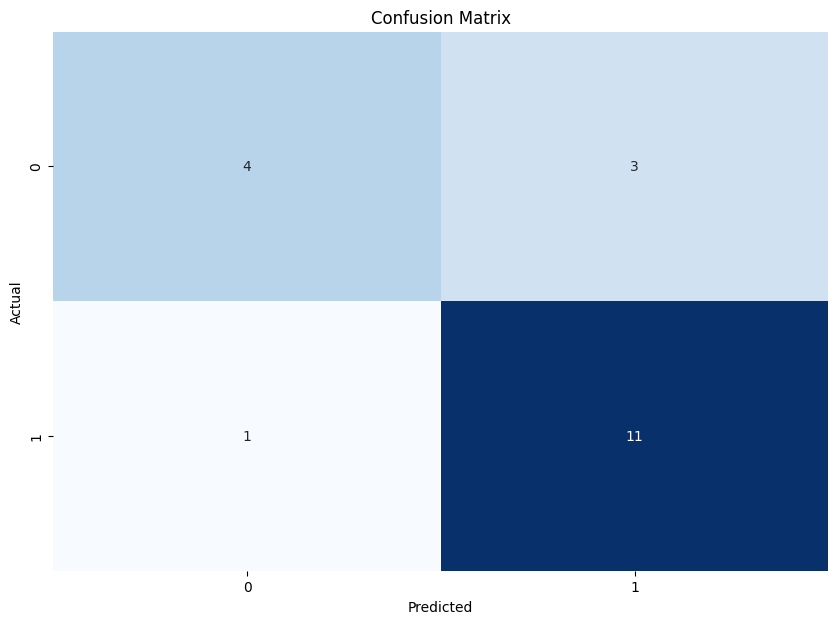

Accuracy: 0.7894736842105263
Precision: 0.7909774436090226
Recall: 0.7894736842105263
F1 Score: 0.7800269905533063
ROC AUC Score: 0.744047619047619


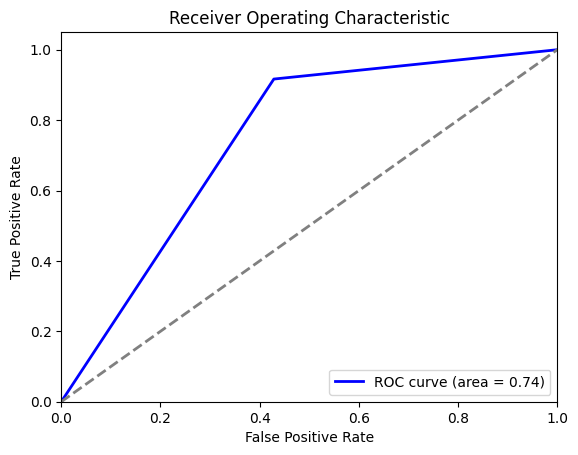

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.79      0.92      0.85        12

    accuracy                           0.79        19
   macro avg       0.79      0.74      0.76        19
weighted avg       0.79      0.79      0.78        19

rc_state_xte:(19, 79360, 640)
input_repr_xte:(19, 410240)
* report :               precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.79      0.92      0.85        12

    accuracy                           0.79        19
   macro avg       0.79      0.74      0.76        19
weighted avg       0.79      0.79      0.78        19

 ************** FIN CLASIFICACION  ************************************


In [43]:
# EValuar el modelo
result_eval = my_rc.fit_evaluate (X_test, y_test)

rc_state_xte, rc_dim_state_xte, input_repr_xte, report = result_eval
print (f'rc_state_xte:{rc_state_xte.shape}')
print (f'input_repr_xte:{input_repr_xte.shape}')

## ## ## ## ## ## ## ##
print ('* report :', report)
print (f' ************** FIN CLASIFICACION  ************************************')

In [47]:
rc_state.shape

(28, 79360, 640)

### Búsqueda de parametros óptimos para los modelos del readout utilizando las representaciones internas del RC-ESN en fase de entrenamiento (input_repr) y evaluación o test (input_repr_xte)

In [31]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# Define el espacio de búsqueda de hiperparámetros
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': ['auto', 32, 64, 128],
    'max_iter': [200, 400, 600]
}

# Configurar GridSearchCV
mlp = MLPClassifier (max_iter = 100, early_stopping = True, validation_fraction = 0.1)
grid_search = GridSearchCV (estimator = mlp, param_grid = param_grid, cv = 10,
                                    scoring = 'accuracy', n_jobs = -1, verbose = 2)

# Entrenar el modelo con GridSearchCV
grid_search.fit (input_repr, y_train)

# Mostrar los mejores hiperparámetros
print ("Mejores hiperparámetros encontrados:")
print (grid_search.best_params_)

# Evaluar el modelo con los mejores hiperparámetros
best_mlp   = grid_search.best_estimator_
y_prob     = best_mlp.predict_proba (input_repr_xte)
pred_class = np.argmax (y_prob, axis = 1)
accuracy   = accuracy_score (y_test, pred_class)
print(f'Precisión del modelo MLP con los mejores hiperparámetros: {accuracy:.2f}')

# Evaluar en el conjunto de prueba
y_prob_test     = best_mlp.predict_proba (input_repr_xte)
pred_class_test = np.argmax (y_prob_test, axis = 1)
test_accuracy   = accuracy_score (y_test, pred_class_test)
print(f'Precisión del modelo MLP en el conjunto de prueba: {test_accuracy:.2f}')


Fitting 3 folds for each of 3456 candidates, totalling 10368 fits
Mejores hiperparámetros encontrados:
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 400, 'solver': 'adam'}
[[0.8411306  0.15886939]
 [0.88093656 0.11906344]
 [0.9370115  0.06298852]
 [0.917033   0.08296701]
 [0.8683479  0.13165213]
 [0.8860295  0.1139705 ]
 [0.86115456 0.13884546]
 [0.77500683 0.22499315]
 [0.9161861  0.08381392]
 [0.8728428  0.12715724]
 [0.7418086  0.2581914 ]
 [0.82084453 0.17915547]
 [0.82766473 0.17233525]
 [0.9041737  0.09582635]
 [0.7745222  0.22547781]
 [0.75802106 0.24197893]
 [0.82394636 0.17605366]
 [0.8363864  0.16361363]
 [0.80528545 0.19471452]]
Precisión del modelo MLP con los mejores hiperparámetros: 0.37


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Definir el espacio de búsqueda de hiperparámetros para SVM
param_grid = {
    'C': [0.1, 1, 5, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Inicializar el modelo SVM
svm_model = SVC()

# Configurar GridSearchCV para SVM
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Entrenar el modelo con GridSearchCV para SVM
grid_search_svm.fit(input_repr, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros para SVM encontrados:")
print(grid_search_svm.best_params_)

# Evaluar el modelo con los mejores hiperparámetros
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(input_repr_xte)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'Precisión del modelo SVM con los mejores hiperparámetros: {accuracy_svm:.2f}')


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Mejores hiperparámetros para SVM encontrados:
{'C': 5, 'gamma': 'scale', 'kernel': 'linear'}
Precisión del modelo SVM con los mejores hiperparámetros: 0.68


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# Definir el espacio de búsqueda de hiperparámetros para OVR con Logistic Regression
param_grid_ovr = {
    'ovr__estimator__C': [0.1, 1, 5, 10, 20, 50, 100],
    'ovr__estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'ovr__estimator__gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1, 10]
}

# Configurar GridSearchCV para OVR
ovr = OneVsRestClassifier(LogisticRegression())
grid_search_ovr = GridSearchCV(estimator=ovr, param_grid=param_grid_ovr, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Entrenar el modelo con GridSearchCV para OVR
grid_search_ovr.fit(input_repr, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros para OVR encontrados:")
print(grid_search_ovr.best_params_)

# Evaluar el modelo con los mejores hiperparámetros
best_ovr = grid_search_ovr.best_estimator_
y_pred_ovr = best_ovr.predict(input_repr_xte)
accuracy_ovr = accuracy_score(y_test, y_pred_ovr)
print(f'Precisión del modelo OVR con los mejores hiperparámetros: {accuracy_ovr:.2f}')


Fitting 3 folds for each of 14 candidates, totalling 42 fits
Mejores hiperparámetros para OVR encontrados:
{'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}
Precisión del modelo OVR con los mejores hiperparámetros: 0.68


In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# Definir el espacio de búsqueda de hiperparámetros para RidgeClassifier
param_grid_ridge = {
    'alpha': [0.1, 1, 10, 100],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# Configurar GridSearchCV para RidgeClassifier
grid_search_ridge = GridSearchCV(estimator=RidgeClassifier(), param_grid=param_grid_ridge, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Entrenar el modelo con GridSearchCV para RidgeClassifier
grid_search_ridge.fit(input_repr, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros para Ridge encontrados:")
print(grid_search_ridge.best_params_)

# Evaluar el modelo con los mejores hiperparámetros
best_ridge = grid_search_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(input_repr_xte)
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
print(f'Precisión del modelo Ridge con los mejores hiperparámetros: {accuracy_ridge:.2f}')


Fitting 3 folds for each of 28 candidates, totalling 84 fits
Mejores hiperparámetros para Ridge encontrados:
{'alpha': 0.1, 'solver': 'auto'}
Precisión del modelo Ridge con los mejores hiperparámetros: 0.68


# DeepMyRC

In [ ]:
!git clone https://github.com/pik-copan/pyunicorn.git
%cd pyunicorn
!pip install .
!pip install pyts

In [ ]:
import torch
import numpy as np
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

import scipy.io
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd

from matplotlib.pyplot import cm

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import v_measure_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import pdist, squareform
from sklearn.multiclass import OneVsRestClassifier
from base.tensorPCA import tensorPCA
from base.MyRC_ESN import MyDeepRC

import pprint
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
import scipy.spatial.distance as ssd
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import v_measure_score

#from reservoir_computing.modules import RC_model
#from reservoir_computing.datasets import ClfLoader

np.random.seed(0) # Fix the seed for reproducibility

import torch
import numpy as np
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

import scipy.io
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd

from matplotlib.pyplot import cm

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import v_measure_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import pdist, squareform
from sklearn.multiclass import OneVsRestClassifier
from base.tensorPCA import tensorPCA
from base.MyRC_ESN import MyDeepRC

from base.MyRC_ESN import print_prediction_results, calculate_dtw_distance, calculate_mean_absolute_error
from base.MyRC_ESN import calculate_mean_squared_error, calculate_pearson_correlation, normalize_time_series

# Todos los canales con eliminación de artefactos

In [ ]:
old   = np.load('./dtset/dt_Older_eeg_ICA_30_4.npy')
young = np.load('./dtset/dt_Younger_eeg_ICA_30_4.npy')

# Todos los canales sin eliminación de artefactos

In [ ]:
old = np.load('./dtset/dt_Older_eeg_30_4.npy')
young = np.load('./dtset/dt_Younger_eeg_30_4.npy')

# Filtramos los canales

In [ ]:
eeg_channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

# Definición de los subgrupos de canales
coronal_subgroups = {
    "prefrontal": ['Fp1', 'Fp2', 'AF7', 'AF8', 'AF3', 'AF4', 'AFz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'Fz'],
    "frontal": ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'Fz'],
    "central": ['C3', 'C4', 'Cz'],
    "parietal": ['P3', 'P4', 'Pz'],
    "occipital": ['O1', 'O2', 'Oz']
}

sagittal_subgroups = {
    "left": ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1'],
    "center": ['Fpz', 'AFz', 'Fz', 'Cz', 'Pz', 'Oz', 'POz', 'CPz'],
    "right": ['Fp2', 'AF8', 'AF4', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
}

# Función para obtener los índices
def get_indices(subgroup, eeg_channels):
    return [eeg_channels.index(ch) for ch in subgroup if ch in eeg_channels]

# Obtener los índices para cada subgrupo coronal
coronal_indices = {region: get_indices(channels, eeg_channels) for region, channels in coronal_subgroups.items()}

# Obtener los índices para cada subgrupo sagital
sagittal_indices = {region: get_indices(channels, eeg_channels) for region, channels in sagittal_subgroups.items()}

print("Coronal indices:", coronal_indices)
print("Sagittal indices:", sagittal_indices)


idx_channels = sagittal_indices ['left']  #coronal_indices ['frontal'] + coronal_indices ['prefrontal']
print("Frontal indices:", idx_channels)


Coronal indices: {'prefrontal': [0, 33, 1, 34, 2, 35, 36, 3, 38, 4, 39, 5, 40, 6, 41, 37], 'frontal': [3, 38, 4, 39, 5, 40, 6, 41, 37], 'central': [12, 49, 47], 'parietal': [20, 57, 30], 'occipital': [26, 63, 28]}
Sagittal indices: {'left': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26], 'center': [32, 36, 37, 47, 30, 28, 29, 31], 'right': [33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]}
Frontal indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


# Número de canales de entrada

In [ ]:
num_input = len (eeg_channels)

In [ ]:
min_length = min(young.shape [1], old.shape [1])

# Recortar los datasets para que tengan el mismo tamaño
young = young[:,:min_length,0:num_input]
old = old[:,:min_length,0:num_input]
# young = young [ :, :, idx_channels]
# old   = old [:, :, idx_channels]

# Concatenar los datasets
X = np.concatenate((young, old), axis=0)

# Estandarizamos

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def standardize_eeg_signals_opt (X):
    """
    Estandariza las señales de EEG para cada canal de cada sujeto.

    Args:
        X (np.ndarray): Datos de entrada con forma (n_subjects, n_samples, n_channels).

    Returns:
        X_standardized (np.ndarray): Datos estandarizados con la misma forma que X.
    """
    # Copiar X para almacenar los datos estandarizados
    X_standardized = np.copy(X)

    # Función para estandarizar un canal completo
    def standardize_channel (channel_data):
        scaler = StandardScaler ()
        return scaler.fit_transform (channel_data.reshape (-1, 1)).flatten ()

    # Aplicar la estandarización a cada canal para cada sujeto
    for i in range (X.shape [0]):  # Iterar sobre cada sujeto
        X_standardized [i] = np.apply_along_axis (standardize_channel, 0, X [i])

    return X_standardized
# Crear el normalizador Min-Max
scaler = StandardScaler()

# Ajustar y transformar los datos
# X = scaler.fit_transform(X.reshape(-1, 1)).reshape(X.shape[0], X.shape[1], X.shape[2])
X = standardize_eeg_signals_opt (X)
# Verificar las formas resultantes
print("Forma de los datos concatenados:", X.shape)

Forma de los datos concatenados: (47, 39680, 64)


In [ ]:


deep_esn_config = {
    'seed': 1,
    'layers': [
        {  'init_type':'orthogonal',
            'init_std':0.01,
            'init_mean':0,
            'input_size': 64,
            'n_internal_units': 480,
            'spectral_radius': 1,
            'leak': 0.3,
            'input_scaling': 1.0,
            'connectivity': 0.1,
            'noise_level': 0.01,
            'nonlinearity': 'relu',
            'use_input_bias': True,
            'use_input_layer': True,
            'circle': False,
            'plasticity_synaptic':None,
            'theta_m':0.01,
            'plasticity_intrinsic':None,
            'learning_rate':0.9,
            'new_activation_function':'tanh',
            'excitability_factor':0.01,
            'device':'cpu'
        },
        { 'init_type':'orthogonal',
            'init_std':0.01,
            'init_mean':0,
            'input_size': 480,
            'n_internal_units': 240,
            'spectral_radius': 1,
            'leak': 0.2,
            'input_scaling': 1.0,
            'connectivity': 0.1,
            'noise_level': 0.1,
            'nonlinearity': 'relu',
            'use_input_bias': True,
            'use_input_layer': True,
            'circle': False,
            'plasticity_synaptic':None,
            'theta_m':0.01,
            'plasticity_intrinsic':None,
            'learning_rate':0.9,
            'new_activation_function':'tanh',
            'excitability_factor':0.01,
            'device':'cpu'
        },
        { 'init_type':'orthogonal',
            'init_std':0.01,
            'init_mean':0,
            'input_size': 240,
            'n_internal_units': 120,
            'spectral_radius': 1,
            'leak': 0.23,
            'input_scaling': 0.1,
            'connectivity': 0.1,
            'noise_level': 0.01,
            'nonlinearity': 'relu',
            'use_input_bias': True,
            'use_input_layer': True,
            'circle': False,
            'plasticity_synaptic':None,
            'theta_m':0.01,
            'plasticity_intrinsic':None,
            'learning_rate':0.9,
            'new_activation_function':'tanh',
            'excitability_factor':0.01,
            'device':'cpu'
        }
    ],
    'nonlinearity': 'relu',  # 'relu','tanh' para mlp
    'use_input_bias': True,
    'readout_type': None,  # Ridge regression
    'w_ridge': 5.0,
    'n_drop': None,
    'washout':'init',
    'mts_rep':'reservoir',
    'learning_rate': 0.1,
    'random_state': 1,
    'bidir': False,
    'circle': False,
    'dimred_method': None,
    'n_dim': 44,
    'threshold':0.5,
    'svm_kernel': 'linear',
    'svm_gamma': 0.005,
    'mlp_layout': (100, 100),
    'num_epochs': 2000,
    'mlp_batch_size':32,
    'mlp_learning_rate':0.01,
    'mlp_learning_rate_type':'constant', # 'constant' or 'adaptive'
    'w_l2': 0.001,
    'max_depth':12,
    'n_estimators':100,
    'w_ridge_embedding':10.0,
    'device':'cpu'
}
import numpy as np

deep_rc = MyDeepRC (deep_esn_config)
# EStado de cada capa interna del RC, estados de la ultima capa interna dle RC, estado con reducción dimensionalidad, Representacion interna del RC, Readout
states_per_layer, final_states, red_states, input_repr, output_rc_layer = deep_rc.fit(X)
print ('******************FIN Entrenamiento Deep RC*************')
print('output_rc_layer:', output_rc_layer.shape)
print('final_states:', final_states.shape)
print('states_per_layer:', len(states_per_layer))
print('states_per_layer:', states_per_layer[0].shape)
print('red_states:', red_states.shape)
print('input_repr:', input_repr.shape)

dimred_method:None
torch.Size([47, 39680, 64])
torch.Size([47, 39680, 480])
torch.Size([47, 39680, 240])
******************FIN Entrenamiento Deep RC*************
output_rc_layer: (47, 14520)
final_states: torch.Size([47, 39680, 120])
states_per_layer: 3
states_per_layer: torch.Size([47, 39680, 480])
red_states: torch.Size([47, 39680, 120])
input_repr: (47, 14520)


In [ ]:
mts_representations_o = final_states
print(mts_representations_o.shape)

torch.Size([47, 39680, 120])


In [ ]:
# Reshape the matrix to a 2D matrix
mts_representations_o  = mts_representations_o.reshape(47, -1)
mts_representations_o1 = input_repr
#mts_representations_o = np.mean(mts_representations_o, axis=2)
#mts_representations_o = mts_representations_o [:,:,5]

In [ ]:
# Set the colormap for the histogram plot
cmap = cm.tab20(np.linspace(0, 1, 12))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

# Fix the random seed for reproducibility
np.random.seed(0)

# Compute a similarity matrix from the cosine similarity of the representations
similarity_matrix = cosine_similarity (mts_representations_o)
#similarity_matrix = euclidean_distances (mts_representations_o)
similarity_matrix1 = cosine_similarity (mts_representations_o1)
# Normalize the similarity in [0,1]
# Crear el normalizador Min-Max
#scaler = MinMaxScaler()

# Ajustar y transformar los datos
#similarity_matrix = scaler.fit_transform(similarity_matrix)

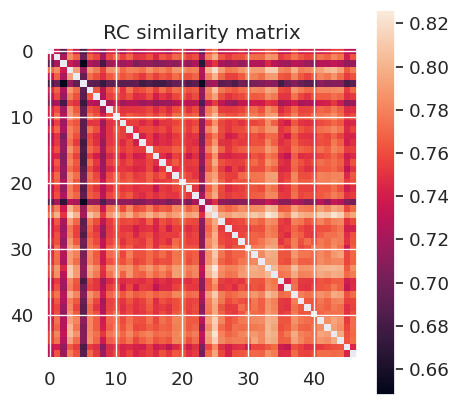

In [ ]:
np.fill_diagonal(similarity_matrix, np.nan)

# Plot similarity matrix
fig =  plt.figure(figsize=(5,5))
h = plt.imshow(similarity_matrix)
plt.title("RC similarity matrix")
plt.colorbar(h)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_classification_report_table(report):
    lines = report.split('\n')

    classes = []
    metrics = ['precision', 'recall', 'f1-score', 'support']
    data = {'Class': [], 'Metric': [], 'Score': []}

    for line in lines[2:(len(lines)-5)]:
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        for i in range(1, 5):
            data['Class'].append(t[0])
            data['Metric'].append(metrics[i-1])
            data['Score'].append(float(t[i]))

    accuracy   = None
    suport_acc = None
    for line in lines:
        line = line.strip()
        if line.startswith('accuracy'):
            accuracy_line = line.strip().split()
            try:
                accuracy   = float(accuracy_line[-2])  # Tomamos el último elemento como accuracy
                suport_acc = float(accuracy_line[-1])  # Tomamos el último elemento como support
            except ValueError:
                accuracy = None
            break

    df = pd.DataFrame(data)

    plt.figure(figsize=(10, 6))

    # Crear tabla con Seaborn
    ax = sns.heatmap(pd.pivot_table(df, values='Score', index='Class', columns='Metric'),
                     annot=True, fmt=".2f", cmap="YlGnBu", cbar=False,
                     annot_kws={"fontsize": 12})  # Ajustar tamaño de fuente de las anotaciones

    # Añadir accuracy como título
    if accuracy is not None:
        plt.title(f'Classification Report\nAccuracy: {accuracy:.2f} . support: {suport_acc}', fontsize=14, color='red')
    else:
        plt.title('Classification Report', fontsize=14, color='red')

    plt.tight_layout()
    plt.show()

def plot_classification_report_dic_table(report_dict):
    # Extract relevant metrics from the report dictionary
    classes = ['0', '1']  # Assuming classes are fixed for your case
    metrics = ['precision', 'recall', 'f1-score', 'support']

    data = {'Class': [], 'Metric': [], 'Score': []}

    # Extract per-class metrics
    for cls in classes:
        for metric in metrics:
            data['Class'].append(cls)
            data['Metric'].append(metric)
            data['Score'].append(report_dict[cls][metric])

    # Extract macro avg metrics
    for metric in metrics:
        data['Class'].append('macro avg')
        data['Metric'].append(metric)
        data['Score'].append(report_dict['macro avg'][metric])

    # Extract weighted avg metrics
    for metric in metrics:
        data['Class'].append('weighted avg')
        data['Metric'].append(metric)
        data['Score'].append(report_dict['weighted avg'][metric])

    # Extract accuracy
    accuracy = report_dict['accuracy']

    df = pd.DataFrame(data)

    plt.figure(figsize=(10, 6))

    # Create table using Seaborn
    ax = sns.heatmap(pd.pivot_table(df, values='Score', index='Class', columns='Metric'),
                     annot=True, fmt=".2f", cmap="YlGnBu", cbar=False,
                     annot_kws={"fontsize": 12})  # Adjust annotation font size

    # Highlight accuracy in red if available
    if accuracy is not None:
        for text in ax.texts:
            if text.get_text() == f'{accuracy:.2f}':
                text.set_color('red')  # Change accuracy text color to red
                text.set_weight('bold')  # Make accuracy text bold
        plt.title(f'Classification Report\nAccuracy: {accuracy:.2f}', fontsize=14, color='red')
    else:
        plt.title('Classification Report', fontsize=14)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(labels, labels_pred):
    # Calcular matriz de confusión
    cm = confusion_matrix(labels, labels_pred)

    # Obtener etiquetas únicas
    classes = np.unique(labels)

    # Crear plot de la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
# Crear etiquetas: 0 para 'young' y 1 para 'old'
labels_young = np.zeros(young.shape[0], dtype=int)
labels_old = np.ones(old.shape[0], dtype=int)

# Concatenar las etiquetas
true_y  = np.concatenate((labels_young, labels_old))
true_y_ = np.concatenate((labels_old, labels_young ))
print("Etiquetas verdaderas (true_y):")
print(true_y)
print(true_y_)

Etiquetas verdaderas (true_y):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 1 0 1 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1]


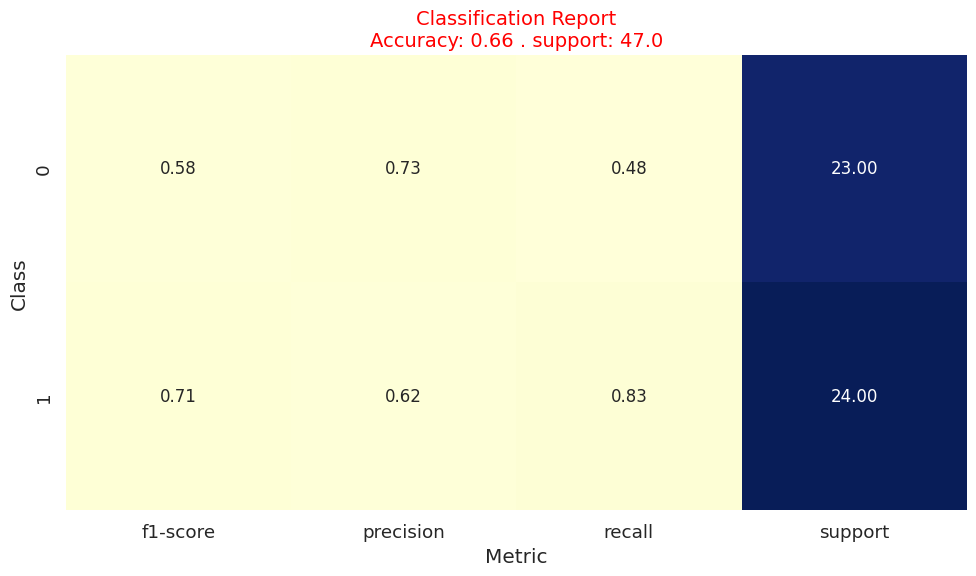

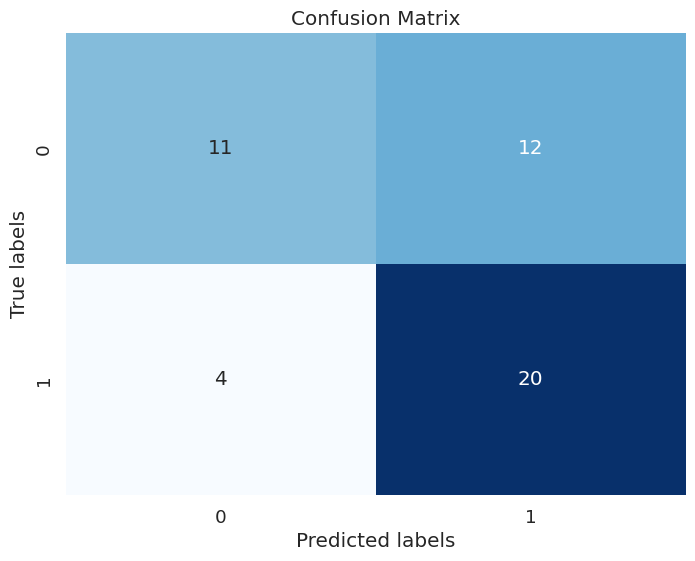

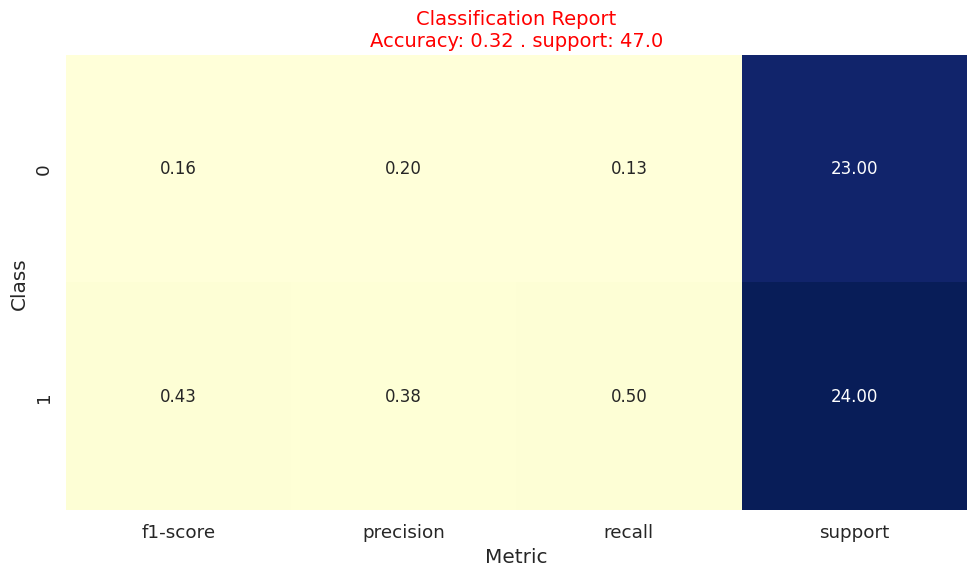

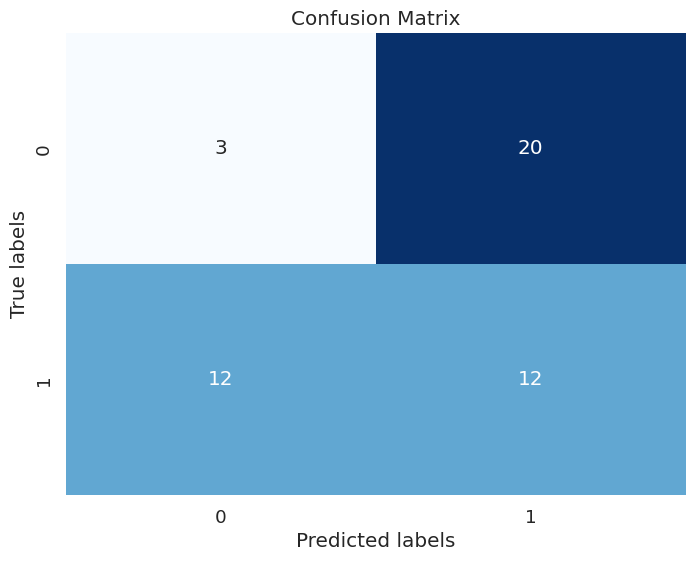

In [ ]:
from sklearn.metrics import classification_report
np.fill_diagonal(similarity_matrix, 0)
kmeans1      = KMeans (n_clusters = 2) # ,init='k-means++', random_state=0
kmeans1.fit_transform (similarity_matrix)
print (kmeans1.labels_)

report = classification_report(true_y, kmeans1.labels_)
plot_classification_report_table (report)
plot_confusion_matrix(true_y, kmeans1.labels_)

report = classification_report(true_y_, kmeans1.labels_)
plot_classification_report_table (report)
plot_confusion_matrix(true_y_, kmeans1.labels_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0]


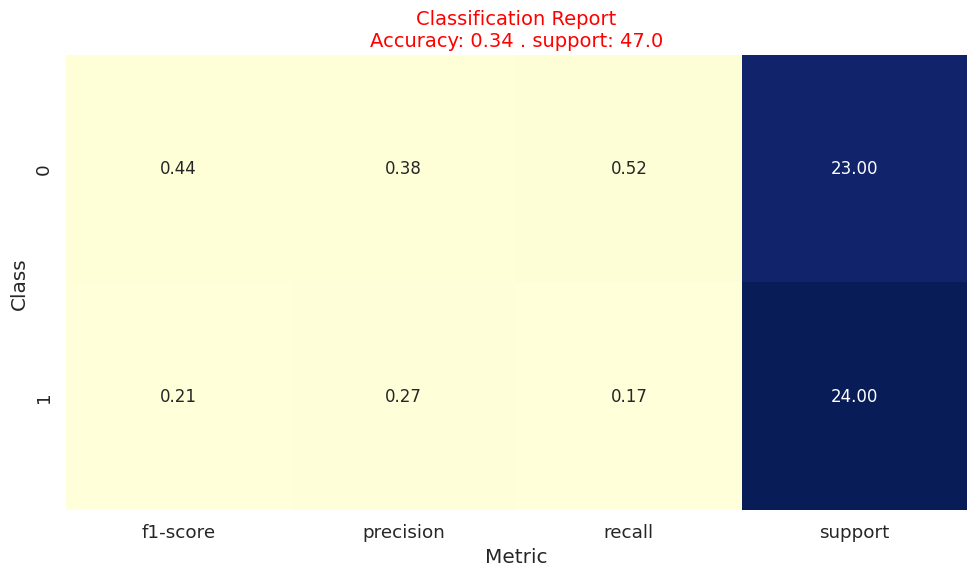

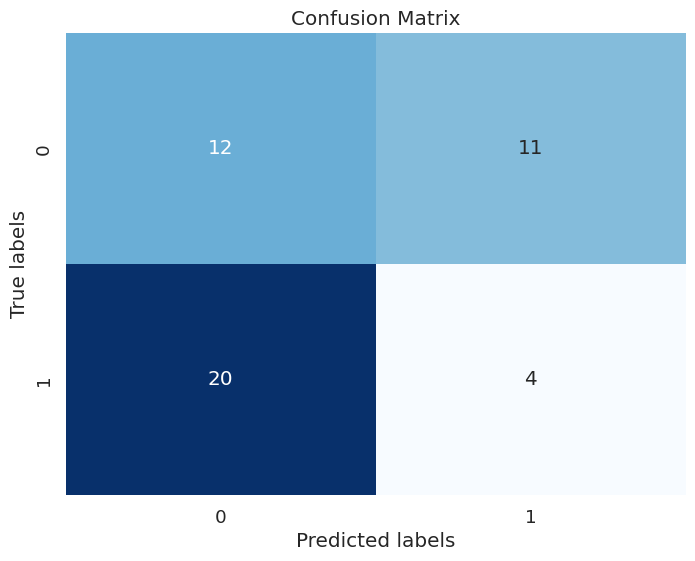

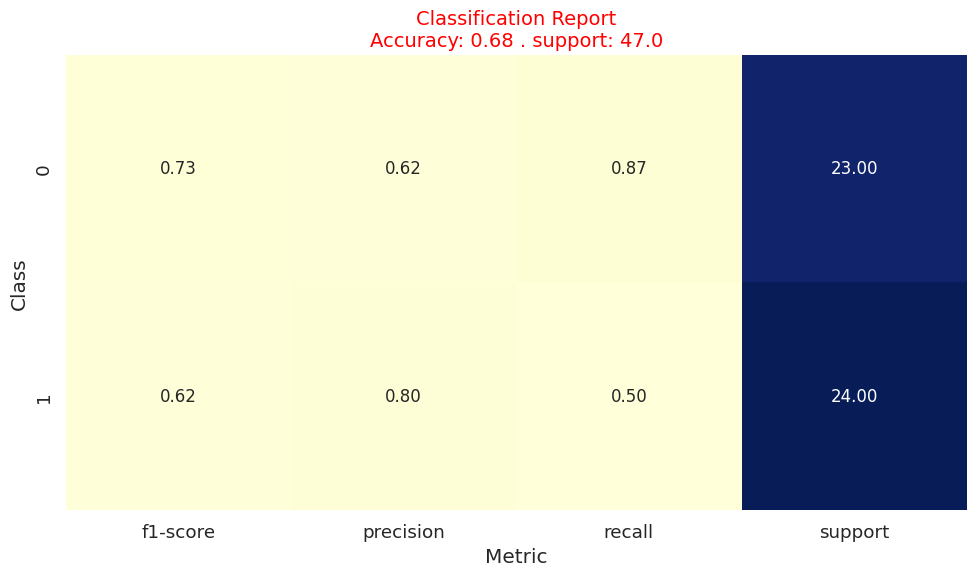

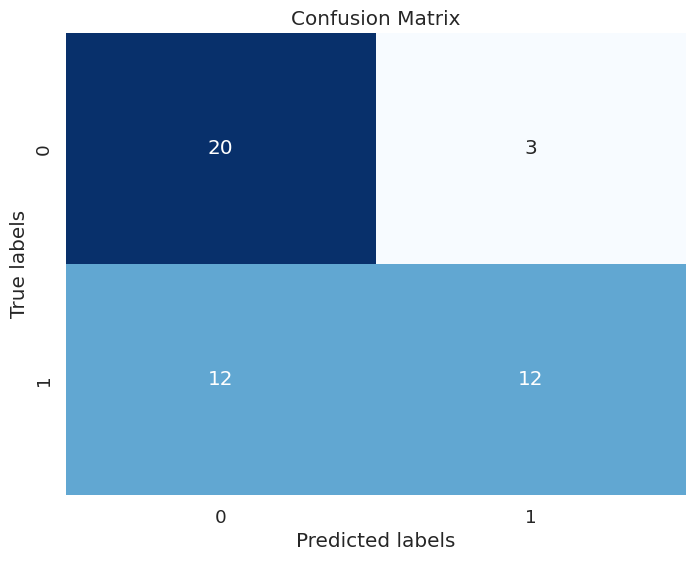

In [ ]:
from sklearn.metrics import classification_report
np.fill_diagonal(similarity_matrix1, 0)
kmeans1      = KMeans (n_clusters = 2) # ,init='k-means++', random_state=0
kmeans1.fit_transform (similarity_matrix)
print (kmeans1.labels_)

report = classification_report(true_y, kmeans1.labels_)
plot_classification_report_table (report)
plot_confusion_matrix(true_y, kmeans1.labels_)

report = classification_report(true_y_, kmeans1.labels_)
plot_classification_report_table (report)
plot_confusion_matrix(true_y_, kmeans1.labels_)

Best Accuracy: 0.723404255319149
Best Report: {'0': {'precision': 0.6666666666666666, 'recall': 0.8695652173913043, 'f1-score': 0.7547169811320754, 'support': 23}, '1': {'precision': 0.8235294117647058, 'recall': 0.5833333333333334, 'f1-score': 0.6829268292682927, 'support': 24}, 'accuracy': 0.723404255319149, 'macro avg': {'precision': 0.7450980392156863, 'recall': 0.7264492753623188, 'f1-score': 0.7188219052001841, 'support': 47}, 'weighted avg': {'precision': 0.7467667918231121, 'recall': 0.723404255319149, 'f1-score': 0.7180581801803565, 'support': 47}}


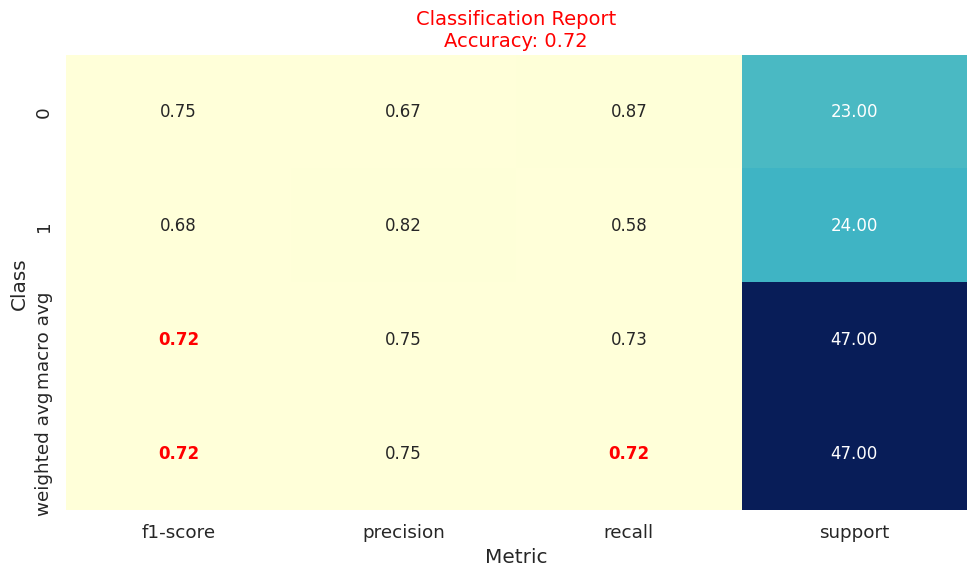

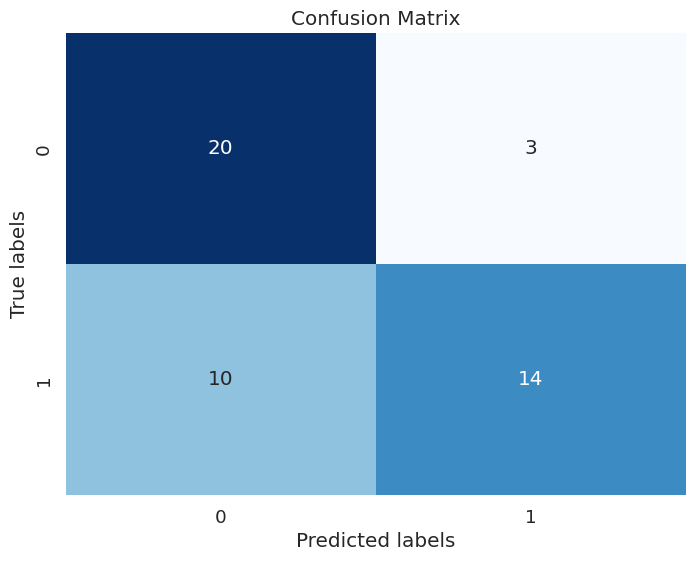

Best Accuracy: 0.6170212765957447
Best Report: {'0': {'precision': 0.8571428571428571, 'recall': 0.2608695652173913, 'f1-score': 0.4, 'support': 23}, '1': {'precision': 0.575, 'recall': 0.9583333333333334, 'f1-score': 0.71875, 'support': 24}, 'accuracy': 0.6170212765957447, 'macro avg': {'precision': 0.7160714285714285, 'recall': 0.6096014492753623, 'f1-score': 0.559375, 'support': 47}, 'weighted avg': {'precision': 0.7130699088145896, 'recall': 0.6170212765957447, 'f1-score': 0.5627659574468086, 'support': 47}}


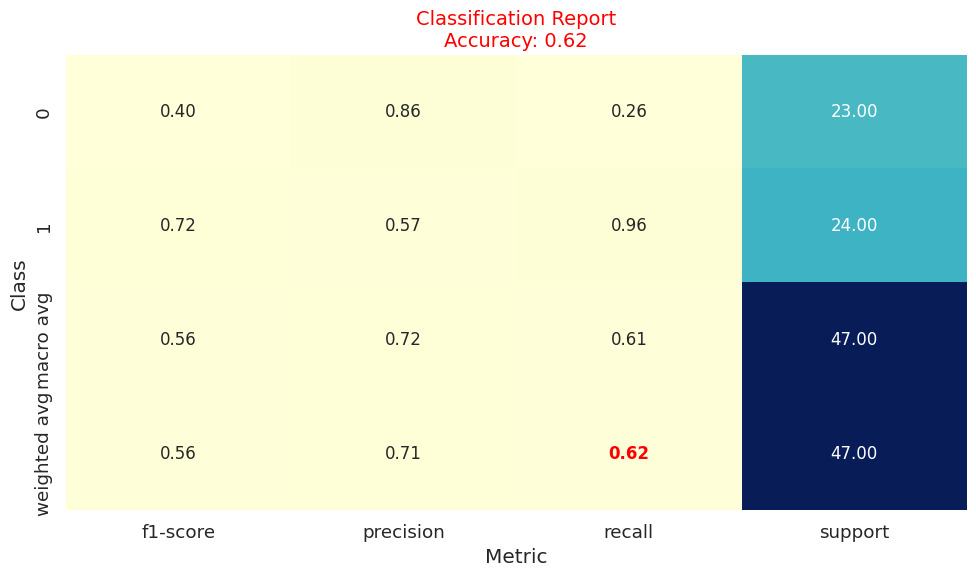

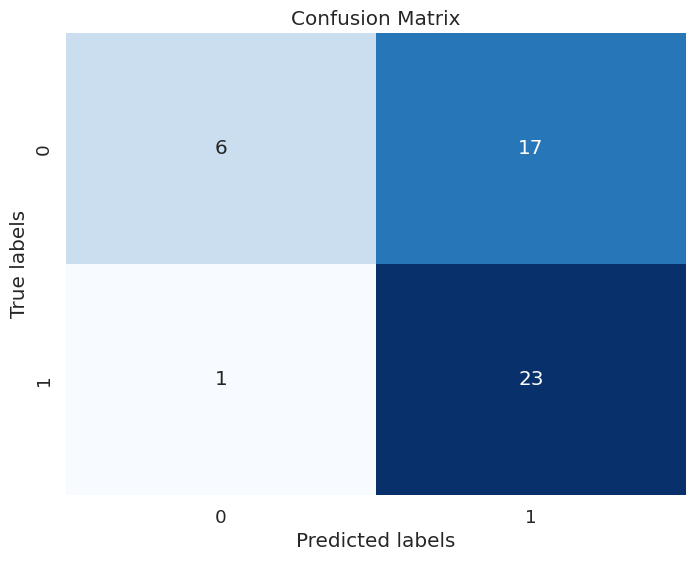

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score

def find_best_kmeans(similarity_matrix, true_labels, n_runs=10, n_clusters=2):
    best_accuracy = 0
    best_labels = None
    best_report = None

    for _ in range(n_runs):
        # Inicializar y ajustar KMeans
        kmeans = KMeans(n_clusters=n_clusters, n_init=10)  # n_init=10 para usar 10 inicializaciones diferentes por cada ajuste
        labels_pred = kmeans.fit_predict(similarity_matrix)

        # Evaluar la precisión
        report = classification_report (true_labels, labels_pred, output_dict = True)
        accuracy = report['accuracy']

        # Si la precisión es la mejor hasta ahora, guardarla
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_labels = labels_pred
            best_report = report

    return best_labels, best_report, best_accuracy

# Suponiendo que true_y es el vector de etiquetas verdaderas y similarity_matrix1 es tu matriz de similitud
np.fill_diagonal(similarity_matrix, 0)
best_labels, best_report, best_accuracy = find_best_kmeans (similarity_matrix, true_y, n_runs = 6500)

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Report: {best_report}")

plot_classification_report_dic_table (best_report)
plot_confusion_matrix(true_y, best_labels)


np.fill_diagonal(similarity_matrix1, 0)
best_labels, best_report, best_accuracy = find_best_kmeans (similarity_matrix1, true_y, n_runs = 6500)

print(f"Best Accuracy: {best_accuracy}")
print(f"Best Report: {best_report}")

plot_classification_report_dic_table (best_report)
plot_confusion_matrix(true_y, best_labels)

(47, 640)


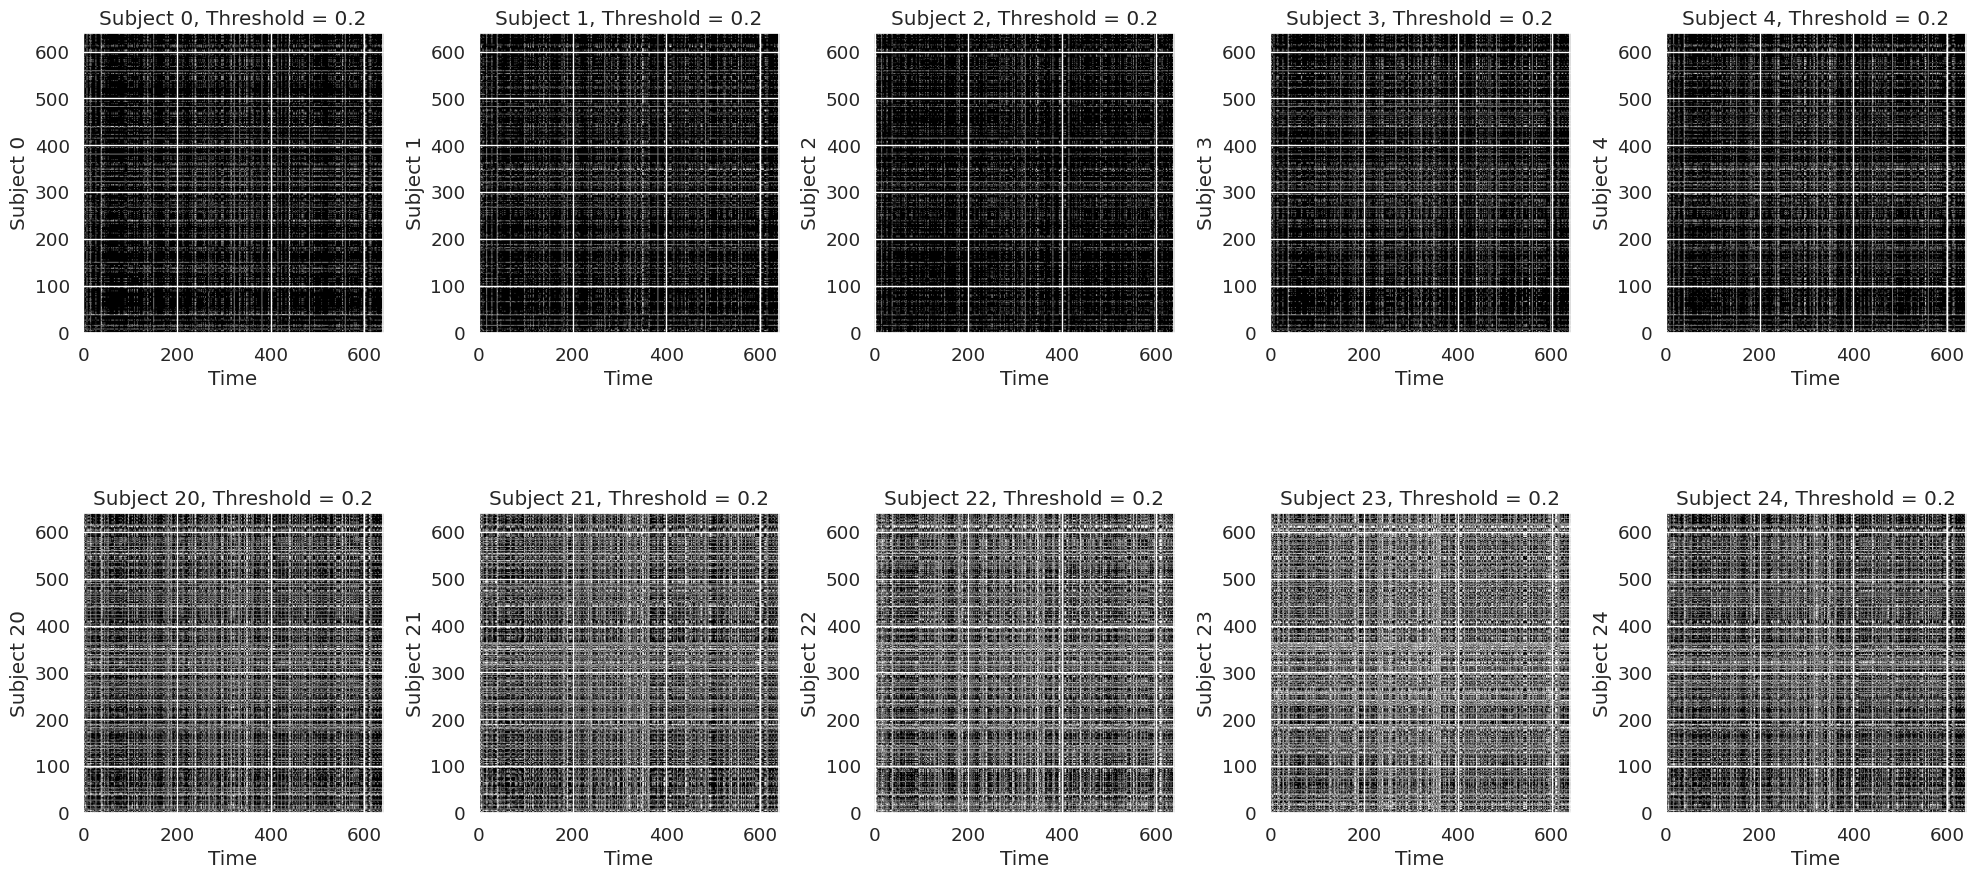

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyunicorn.timeseries.recurrence_plot import RecurrencePlot


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.preprocessing import MinMaxScaler
from pyts.image import RecurrencePlot as Recu

def plot_recurrence_for_subjects(data, thresholds=[0.1, 0.2, 0.3]):
    """
    Genera y visualiza una gráfica recurrente para cada sujeto en el dataset.

    :param data: numpy array de forma (n_sujetos, n_features), donde n_sujetos es el número de sujetos
                 y n_features es la representación interna del RC para cada sujeto.
    :param thresholds: lista de valores de umbral para la recurrencia.
    """
    n_subjects = data.shape[0]

    for subject_index in range(n_subjects):
        # Obtener los datos para el sujeto actual
        subject_data = data[subject_index]

        # Normalizar los datos del sujeto
        #subject_data_normalized = (subject_data - np.mean(subject_data)) / np.std(subject_data)

        for threshold in thresholds:
            # Creación de la gráfica recurrente con el umbral especificado
            rp = RecurrencePlot(subject_data.reshape(-1, 1), threshold=threshold)

            # Obtener la matriz de recurrencia
            recurrence_matrix = rp.recurrence_matrix()

            # Verificación de la matriz de recurrencia
            if np.sum(recurrence_matrix) == 0:
                print(f'La matriz de recurrencia para el sujeto {subject_index} con umbral {threshold} está vacía.')
                continue

            # Visualización de la gráfica recurrente
            plt.figure()
            plt.imshow(recurrence_matrix, cmap='binary', origin='lower')
            plt.xlabel('Time')
            plt.ylabel('Time')
            plt.title(f'Recurrence Plot for Subject {subject_index} with Threshold {threshold}')
            plt.show()

def plot_recurrence_for_subjects_group(data, young_subjects, old_subjects, thresholds=[0.1, 0.2, 0.3]):
    """
    Genera y visualiza matrices de recurrencia para sujetos jóvenes y mayores.

    Parameters:
    data (numpy.ndarray): Datos de representación de los sujetos.
    young_subjects (list): Índices de los sujetos jóvenes.
    old_subjects (list): Índices de los sujetos mayores.
    thresholds (list): Lista de valores de umbral para la recurrencia.
    """
    n_young = len(young_subjects)
    n_old = len(old_subjects)
    n_thresholds = len(thresholds)

    # Calcular número total de subplots necesarios
    n_plots = max(n_young, n_old) * n_thresholds

    # Crear la figura con subplots adecuados
    fig, axes = plt.subplots(nrows=2, ncols=max(n_young, n_old) * n_thresholds, figsize=(20, 10))

    # Iterar sobre los umbrales
    for j, threshold in enumerate(thresholds):
        # Iterar sobre los sujetos jóvenes
        for i, subject_index in enumerate(young_subjects):
            # Determinar el índice correcto del subplot
            subplot_index = i * n_thresholds + j
            ax = axes[0, subplot_index]

            # Obtener datos del sujeto y normalizarlos
            subject_data = data[subject_index]
            subject_data_normalized = MinMaxScaler().fit_transform(subject_data.reshape(-1, 1)).flatten()

            # Crear plot de matriz de recurrencia
            rp = Recu (threshold=threshold)
            recurrence_matrix = rp.fit_transform(subject_data.reshape(1, -1))[0]

            # Mostrar matriz de recurrencia en el subplot correspondiente
            ax.imshow(recurrence_matrix, cmap='binary', origin='lower')
            ax.set_xlabel('Time')
            ax.set_ylabel(f'Subject {subject_index}')
            ax.set_title(f'Subject {subject_index}, Threshold = {threshold}')

        # Iterar sobre los sujetos mayores
        for k, subject_index in enumerate(old_subjects):
            # Determinar el índice correcto del subplot
            subplot_index = k * n_thresholds + j
            ax = axes[1, subplot_index]

            # Obtener datos del sujeto y normalizarlos
            subject_data = data[subject_index]
            subject_data_normalized = MinMaxScaler().fit_transform(subject_data.reshape(-1, 1)).flatten()

            # Crear plot de matriz de recurrencia
            rp = Recu (threshold=threshold)
            recurrence_matrix = rp.fit_transform(subject_data_normalized.reshape(1, -1))[0]

            # Mostrar matriz de recurrencia en el subplot correspondiente
            ax.imshow(recurrence_matrix, cmap='binary', origin='lower')
            ax.set_xlabel('Time')
            ax.set_ylabel(f'Subject {subject_index}')
            ax.set_title(f'Subject {subject_index}, Threshold = {threshold}')

    plt.tight_layout()
    plt.show()

# Ejemplo de uso con datos aleatorios (reemplaza esto con tus datos reales)
mean_transitorios = np.mean(rc_state, axis=1)
last_transitorio = rc_state[ :, -1, :]
mts_rep_reshaped = mean_transitorios #mts_representations_o1
print (mts_rep_reshaped.shape)
young_subjects = [0, 1, 2, 3, 4]   # Ejemplo de índices reducidos
old_subjects = [20, 21, 22, 23, 24]   # Ejemplo de índices reducidos


plot_recurrence_for_subjects_group(mts_rep_reshaped, young_subjects, old_subjects, thresholds=[0.2]) #, 0.2, 0.3

In [ ]:
import numpy as np

def calculate_potential_memory(mts_representations, tolerance = 0.05):
    """
    Calculate the potential memory for given multivariate time series representations.

    Parameters:
    mts_representations (numpy.ndarray): The multivariate time series representations.
    tolerance (float): The tolerance threshold to consider the memory potential. Default is 0.05.

    Returns:
    list: A list containing the potential memory for each representation.
    """
    potential_memory = []

    for representation in mts_representations:
        y_initial = representation[0]

        for t, y_t in enumerate(representation[1:], start=1):
            if np.linalg.norm(y_t - y_initial) < tolerance:
                potential_memory.append(t)
                break
    return potential_memory
################################
# mts_representations = mts_representations_o
mts_representations = mts_representations_o
print("Dimensiones de mts_representations:", mts_representations.shape)

# Verifica los primeros elementos de mts_representations para asegurarte de que estás seleccionando adecuadamente
print("Primeras representaciones de mts_representations:")
for i, rep in enumerate (mts_representations[:2]):
    print(f"\t\t Representación {i}: Shape {rep.shape}")
# Calculate the potential memory for young adult subjects
potential_memory_young_adults = calculate_potential_memory (mts_representations [:23])
# Calculate the potential memory for older subjects
potential_memory_older_adults = calculate_potential_memory (mts_representations [24:])

# Imprimir los resultados
print("Memoria potencial para sujetos jóvenes adultos:", potential_memory_young_adults)
print("Memoria potencial para sujetos mayores:", potential_memory_older_adults)

Dimensiones de mts_representations: torch.Size([47, 4761600])
Primeras representaciones de mts_representations:
		 Representación 0: Shape torch.Size([4761600])
		 Representación 1: Shape torch.Size([4761600])
Memoria potencial para sujetos jóvenes adultos: [9, 6, 92, 92, 9, 73, 6, 9, 9, 6, 28, 6, 130, 6, 9, 10, 73, 6, 6, 9, 6, 28, 9]
Memoria potencial para sujetos mayores: [9, 6, 6, 6, 28, 9, 6, 6, 6, 73, 6, 28, 28, 6, 6, 9, 17, 6, 6, 6, 6, 6, 6]


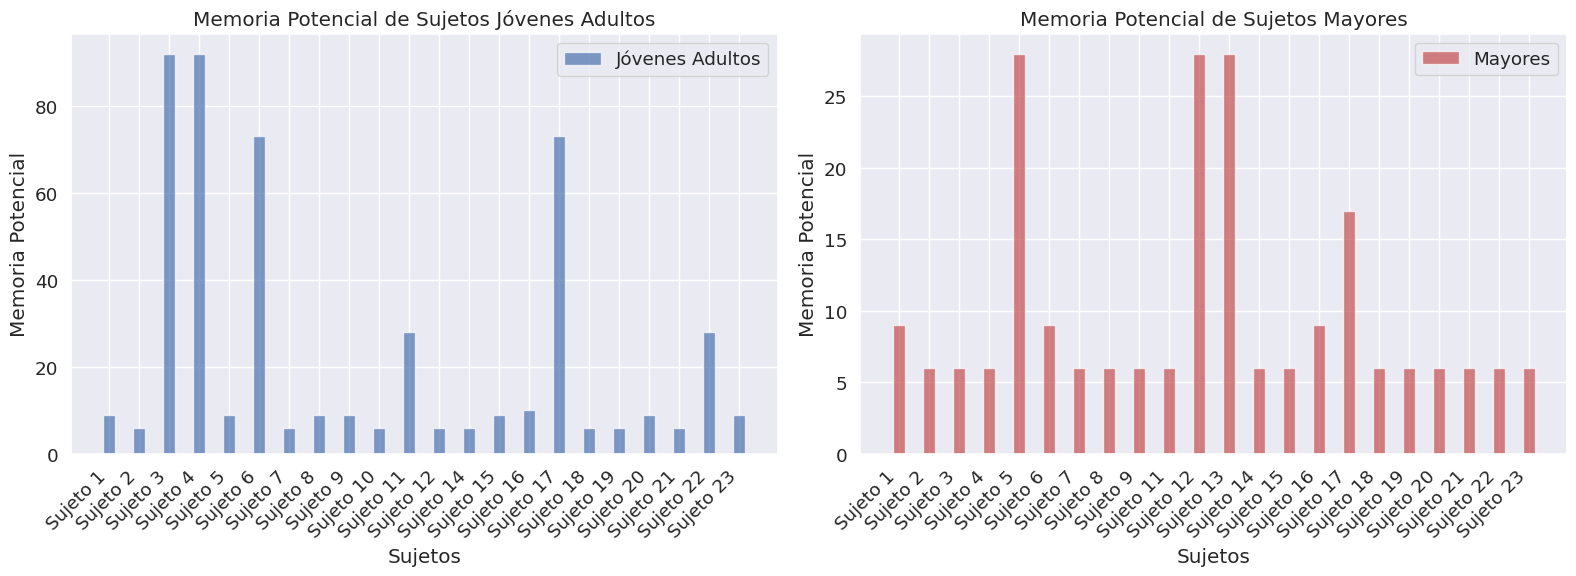

In [ ]:
import matplotlib.pyplot as plt

# Datos de memoria potencial para sujetos jóvenes adultos
# Datos de memoria potencial para sujetos jóvenes adultos
# Datos de memoria potencial para sujetos jóvenes adultos
memoria_jovenes   = [9, 6, 92, 92, 9, 73, 6, 9, 9, 6, 28, 6, 130, 6, 9, 10, 73, 6, 6, 9, 6, 28, 9]
etiquetas_jovenes = [f'Sujeto {i+1}' for i in range (len (memoria_jovenes))]

# Datos de memoria potencial para sujetos mayores
memoria_mayores   =  [9, 6, 6, 6, 28, 9, 6, 6, 6, 73, 6, 28, 28, 6, 6, 9, 17, 6, 6, 6, 6, 6, 6]
etiquetas_mayores = [f'Sujeto {i+1}' for i in range (len (memoria_mayores))]

# Eliminar el valor máximo para poder representar gráficamente los resultados
max_memoria_jovenes = max(memoria_jovenes)
max_memoria_mayores = max(memoria_mayores)

etiquetas_jovenes.remove(etiquetas_jovenes[memoria_jovenes.index(max_memoria_jovenes)])
etiquetas_mayores.remove(etiquetas_mayores[memoria_mayores.index(max_memoria_mayores)])

memoria_jovenes.remove (max_memoria_jovenes)
memoria_mayores.remove (max_memoria_mayores)

# Crear figura y ejes para los dos subplots
fig, (ax1, ax2) = plt.subplots (1, 2, figsize = (16, 6))  # 1 fila, 2 columnas

# Barras para sujetos jóvenes adultos
ax1.bar (etiquetas_jovenes, memoria_jovenes, width = 0.4, align = 'center', label = 'Jóvenes Adultos', color = 'b', alpha = 0.7)

# Etiquetas y título para el primer subplot
ax1.set_xlabel ('Sujetos')
ax1.set_ylabel ('Memoria Potencial')
ax1.set_title ('Memoria Potencial de Sujetos Jóvenes Adultos')
ax1.set_xticks (range (len (etiquetas_jovenes)))
ax1.set_xticklabels (etiquetas_jovenes, rotation = 45, ha = 'right')
ax1.legend ()

# Barras para sujetos mayores
ax2.bar (etiquetas_mayores, memoria_mayores, width = 0.4, align = 'center', label = 'Mayores', color = 'r', alpha = 0.7)

# Etiquetas y título para el segundo subplot
ax2.set_xlabel ('Sujetos')
ax2.set_ylabel ('Memoria Potencial')
ax2.set_title ('Memoria Potencial de Sujetos Mayores')
ax2.set_xticks (range(len(etiquetas_mayores)))
ax2.set_xticklabels (etiquetas_mayores, rotation = 45, ha = 'right')
ax2.legend ()

# Ajustar diseño y mostrar la figura con ambos subplots
plt.tight_layout ()
plt.show ()